# Introduction
The Amazon "Buy Box" (the prominent section on a product page with the "Add to Cart" or "Buy Now" button) is arguably the most critical element for seller success on the marketplace. Winning the Buy Box placement drives the overwhelming majority of sales for a given product. However, the process determining which seller wins is complex, dynamic, and driven by Amazon's proprietary algorithms, which consider factors like price, fulfillment method (FBA), shipping speed, seller ratings, stock availability, and more.

**Why this analysis?** Understanding the dynamics of the Buy Box is crucial for sellers aiming to optimize their strategies, pricing, and operations to maximize their chances of winning this coveted spot. For marketplace analysts, researchers, or platform owners, understanding these dynamics reveals insights into market competition, pricing strategies (including algorithmic pricing), and the effectiveness of different fulfillment models.

**What does this notebook do?** This notebook performs a comprehensive analysis of historical Amazon marketplace data (likely scraped offer listings over time) to dissect the Buy Box phenomenon. It aims to answer key questions such as:

*   **Data Foundation:** How can we efficiently load, clean, and prepare potentially massive datasets for analysis?
*   **Market Velocity:** How quickly do prices (seller offers, Buy Box price) and Buy Box winners change?
*   **Seller Influence:** What seller characteristics (ratings, feedback count, FBA status, Prime eligibility) correlate with Buy Box success?
*   **Amazon's Role:** How does Amazon's presence as a seller impact pricing and Buy Box allocation?
*   **Rank Importance:** How strongly does a seller's rank on the offer listing page predict their likelihood of winning the Buy Box?
*   **Predictive Factors:** Can we build a model to predict the Buy Box winner, and what features are most important according to the model (e.g., price relative to competitors, seller metrics)?
*   **Product-Level Dynamics:** How does price competition and Buy Box ownership play out visually for specific products over time?

**Handling Large Datasets:** Marketplace crawl data can be extremely large, often exceeding available RAM on standard machines. This notebook incorporates several optimizations specifically designed to handle this challenge:
*   **Memory-Efficient Data Loading:** Uses optimized data types (`category`, `float32`, smaller integers) during loading.
*   **Optional Sampling:** Implements a `USE_SAMPLE` flag and `SAMPLE_SIZE_PIDS` parameter to allow working with a manageable subset of products for initial exploration and development. **It is strongly recommended to start with `USE_SAMPLE = True` for large datasets.**
*   **Efficient Computations:** Leverages vectorized operations in `pandas` where possible (e.g., for update frequency calculations).
*   **Memory-Conscious ML:** Employs techniques like using `float32` features, `SGDClassifier` (which processes data in batches), feature scaling, and reduced cross-validation folds.
*   **Garbage Collection:** Includes explicit calls to Python's garbage collector (`gc.collect()`) to help release memory after large objects are deleted.

By executing the analyses within this notebook, we aim to gain data-driven insights into the competitive landscape of the Amazon marketplace and the key levers influencing Buy Box allocation.

 ## Setup: Importing Libraries

Objective: Load all necessary Python packages required for the subsequent analysis.

In [1]:
# Core libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import time
import gc # Garbage Collector interface

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier # Keep RF as an option
from sklearn.linear_model import SGDClassifier # Memory-efficient alternative to LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler # Needed for SGDClassifier

# Optional: Display settings
from IPython.display import display
pd.options.display.max_columns = 50 # Show more columns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")


 ## Configuration Flags

Objective: Define key parameters that control the notebook's execution, especially regarding sampling and ML settings, in one central place.

In [19]:
# --- !!! CRITICAL MEMORY SETTING !!! ---
# Set USE_SAMPLE to True if your dataset is large and causing memory errors.
# Start with a small SAMPLE_SIZE_PIDS and increase if memory allows.
USE_SAMPLE = True  # Default to True for safety with large datasets
SAMPLE_SIZE_PIDS = 5000 # Number of unique products to sample if USE_SAMPLE is True
N_SPLITS_CV = 3 # Number of folds for Cross-Validation (reduce to save memory)

# Define Amazon Seller ID (verify this from your data if possible)
AMAZON_SELLER_ID = 'AMAZON'


 ## A. Data Loading and Preparation (Optimized)



Objective: Load the raw crawl2.txt data into a pandas DataFrame, perform essential cleaning, engineer basic features, optimize data types for memory efficiency, and potentially create a smaller analysis_data sample.

In [8]:
# --- Define Column Names and Optimized Data Types ---
print("Defining column names and optimal data types...")
col_names = ["pid", "epoc", "sid", "price", "sid_rating", "sid_pos_fb",
             "sid_rating_cnt", "shipping", "page", "rank", "pid_rating",
             "pid_rating_cnt", "is_fba", "is_prime", "bbox_sid", "bbox_price"]

# Specify dtypes for memory efficiency during loading
# Use 'category' for high-cardinality strings like pid, sid
# Use smaller integers/floats where possible
dtypes = {
    "pid": "category",
    "epoc": np.float64, # Keep as float initially for precise conversion
    "sid": "category",
    "price": np.float32,
    "sid_rating": np.float32,
    "sid_pos_fb": np.float32,
    "sid_rating_cnt": pd.Int32Dtype(), # Use nullable Int32
    "shipping": "string", # Use pandas string type
    "page": pd.Int8Dtype(), # Page number likely small
    "rank": pd.Int16Dtype(), # Rank likely fits in 16-bit int
    "pid_rating": np.float32,
    "pid_rating_cnt": pd.Int32Dtype(),
    "is_fba": "string", # Load as string first, then convert to bool
    "is_prime": "string",
    "bbox_sid": "category",
    "bbox_price": np.float32
}
# Columns to actually load (if you know some are completely unused)
# use_cols = col_names # Load all by default

# --- Load Raw Data ---
print("Loading crawl data with optimized types...")
try:
    start_load_time = time.time()
    crawl_data = pd.read_table(
        "crawl2.txt",
        header=None,
        names=col_names,
        sep='\t',
        # usecols=use_cols, # Optional: Only load needed columns
        dtype=dtypes,
        low_memory=True # Generally True is fine with specified dtypes
    )
    load_time = time.time() - start_load_time
    print(f"Loaded {len(crawl_data)} rows from crawl2.txt in {load_time:.2f} seconds.")
        # --- ADD THIS INSPECTION STEP ---
    print("\nColumns loaded into crawl_data:")
    print(crawl_data.columns.tolist())
    print("\nFirst few rows (head):")
    display(crawl_data.head())
    # --- END INSPECTION STEP ---
    print("\nInitial memory usage:")
    crawl_data.info(memory_usage='deep')

except FileNotFoundError:
    print("Error: crawl2.txt not found. Please ensure the file is in the correct directory.")
    crawl_data = pd.DataFrame(columns=col_names).astype(dtypes) # Empty df with types

except Exception as e:
    print(f"An error occurred during loading: {e}")
    print("Check file path, format, column names, and dtypes.")
    crawl_data = pd.DataFrame(columns=col_names).astype(dtypes)

# --- Load Seller Lists (Small files, less critical for optimization) ---
print("\nLoading seller lists...")
try:
    prime_sids_df = pd.read_table("prime_sids.txt", header=None, names=["prime_sids"])
    prime_sid_set = set(prime_sids_df["prime_sids"])
    print(f"Loaded {len(prime_sid_set)} prime seller IDs.")
    del prime_sids_df # Clean up
except FileNotFoundError:
    print("Warning: prime_sids.txt not found. 'prime_seller' column will be False.")
    prime_sid_set = set()

try:
    algo_sellers_df = pd.read_table("susp_sids_all_with_amazon.txt", header=None, names=["algo_sids"])
    algo_sid_set = set(algo_sellers_df["algo_sids"])
    print(f"Loaded {len(algo_sid_set)} suspected algorithmic seller IDs.")
    del algo_sellers_df # Clean up
except FileNotFoundError:
    print("Warning: susp_sids_all_with_amazon.txt not found. 'algo_seller' column will be False.")
    algo_sid_set = set()


Defining column names and optimal data types...
Loading crawl data with optimized types...
Loaded 20740268 rows from crawl2.txt in 106.08 seconds.

Columns loaded into crawl_data:
['pid', 'epoc', 'sid', 'price', 'sid_rating', 'sid_pos_fb', 'sid_rating_cnt', 'shipping', 'page', 'rank', 'pid_rating', 'pid_rating_cnt', 'is_fba', 'is_prime', 'bbox_sid', 'bbox_price']

First few rows (head):


,pid,epoc,sid,price,sid_rating,sid_pos_fb,sid_rating_cnt,shipping,page,rank,pid_rating,pid_rating_cnt,is_fba,is_prime,bbox_sid,bbox_price
0,0975277324,1.439302e+09,A15JJW6SG5GRME,39.990002,5.0,97.0,73911,0,1,2,5.0,2321,yes,yes,amazon,40.360001
1,0975277324,1.439302e+09,A19HZ7QWHIRFQA,35.000000,0.0,0.0,0,6.49,1,7,5.0,2321,yes,no,amazon,40.360001
2,0975277324,1.439302e+09,A1G1QJKXJJSAN2,44.060001,5.0,98.0,3761,3.99,2,9,5.0,2321,no,no,amazon,40.360001
3,0975277324,1.439302e+09,A1H9LQ4XQ5IZ7D,39.990002,5.0,97.0,1577,0,1,1,5.0,2321,yes,yes,amazon,40.360001
4,0975277324,1.439302e+09,A1OUQ84L1EU4IB,36.990002,5.0,100.0,2,6.49,2,1,5.0,2321,no,no,amazon,40.360001



Initial memory usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20740268 entries, 0 to 20740267
Data columns (total 16 columns):
 #   Column          Dtype   
---  ------          -----   
 0   pid             category
 1   epoc            float64 
 2   sid             category
 3   price           float32 
 4   sid_rating      float32 
 5   sid_pos_fb      float32 
 6   sid_rating_cnt  Int32   
 7   shipping        string  
 8   page            Int8    
 9   rank            Int16   
 10  pid_rating      float32 
 11  pid_rating_cnt  Int32   
 12  is_fba          string  
 13  is_prime        string  
 14  bbox_sid        category
 15  bbox_price      float32 
dtypes: Int16(1), Int32(2), Int8(1), category(3), float32(5), float64(1), string(3)
memory usage: 4.4 GB

Loading seller lists...
Loaded 7248 prime seller IDs.
Loaded 543 suspected algorithmic seller IDs.



Processing and cleaning data (optimizing types further)...
Comparing sid and bbox_sid (converting to string for comparison)...
Comparison done in 11.08 sec.
Parsing shipping costs (vectorized)...
Shipping cost parsing done in 28.53 sec.
Data processing complete in 68.18 seconds.

Memory usage after processing and type optimization:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20740268 entries, 0 to 20740267
Data columns (total 22 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pid               category      
 1   sid               category      
 2   price             float32       
 3   sid_rating        float32       
 4   sid_pos_fb        float32       
 5   sid_rating_cnt    Int32         
 6   shipping          string        
 7   page              Int8          
 8   rank              Int16         
 9   pid_rating        float32       
 10  pid_rating_cnt    Int32         
 11  is_fba            bool          
 12  is_prime     

,pid,sid,price,sid_rating,sid_pos_fb,sid_rating_cnt,shipping,page,rank,pid_rating,pid_rating_cnt,is_fba,is_prime,bbox_sid,bbox_price,timestamp,prime_seller,algo_seller,is_amazon_seller,won_bbox,shipping_cost,total_price
15,0975277324,A4V8CU8QU4IUA,36.400002,5.0,96.0,6573,6.49,2,0,5.0,2321,False,False,amazon,40.360001,2015-08-11 14:04:13,False,False,False,False,6.49,42.889999
19,0975277324,AVB9VPPZMOOT8,33.490002,5.0,96.0,2414771,6.49,1,0,5.0,2321,True,False,amazon,40.360001,2015-08-11 14:04:13,False,True,False,False,6.49,39.980003
3,0975277324,A1H9LQ4XQ5IZ7D,39.990002,5.0,97.0,1577,0,1,1,5.0,2321,True,True,amazon,40.360001,2015-08-11 14:04:13,True,False,False,False,0.00,39.990002
4,0975277324,A1OUQ84L1EU4IB,36.990002,5.0,100.0,2,6.49,2,1,5.0,2321,False,False,amazon,40.360001,2015-08-11 14:04:13,False,False,False,False,6.49,43.480003
0,0975277324,A15JJW6SG5GRME,39.990002,5.0,97.0,73911,0,1,2,5.0,2321,True,True,amazon,40.360001,2015-08-11 14:04:13,True,False,False,False,0.00,39.990002



--- Data Quality Checks (on analysis_data) ---
Duplicate seller observations (PID, SID, timestamp): 409654
Timestamps with multiple Buy Box SIDs for the same product: 0

Missing Value Percentages:


Series([], dtype: float64)


Distribution of Key Numeric Features (plotting may be slow):


c:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
c:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
c:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series b

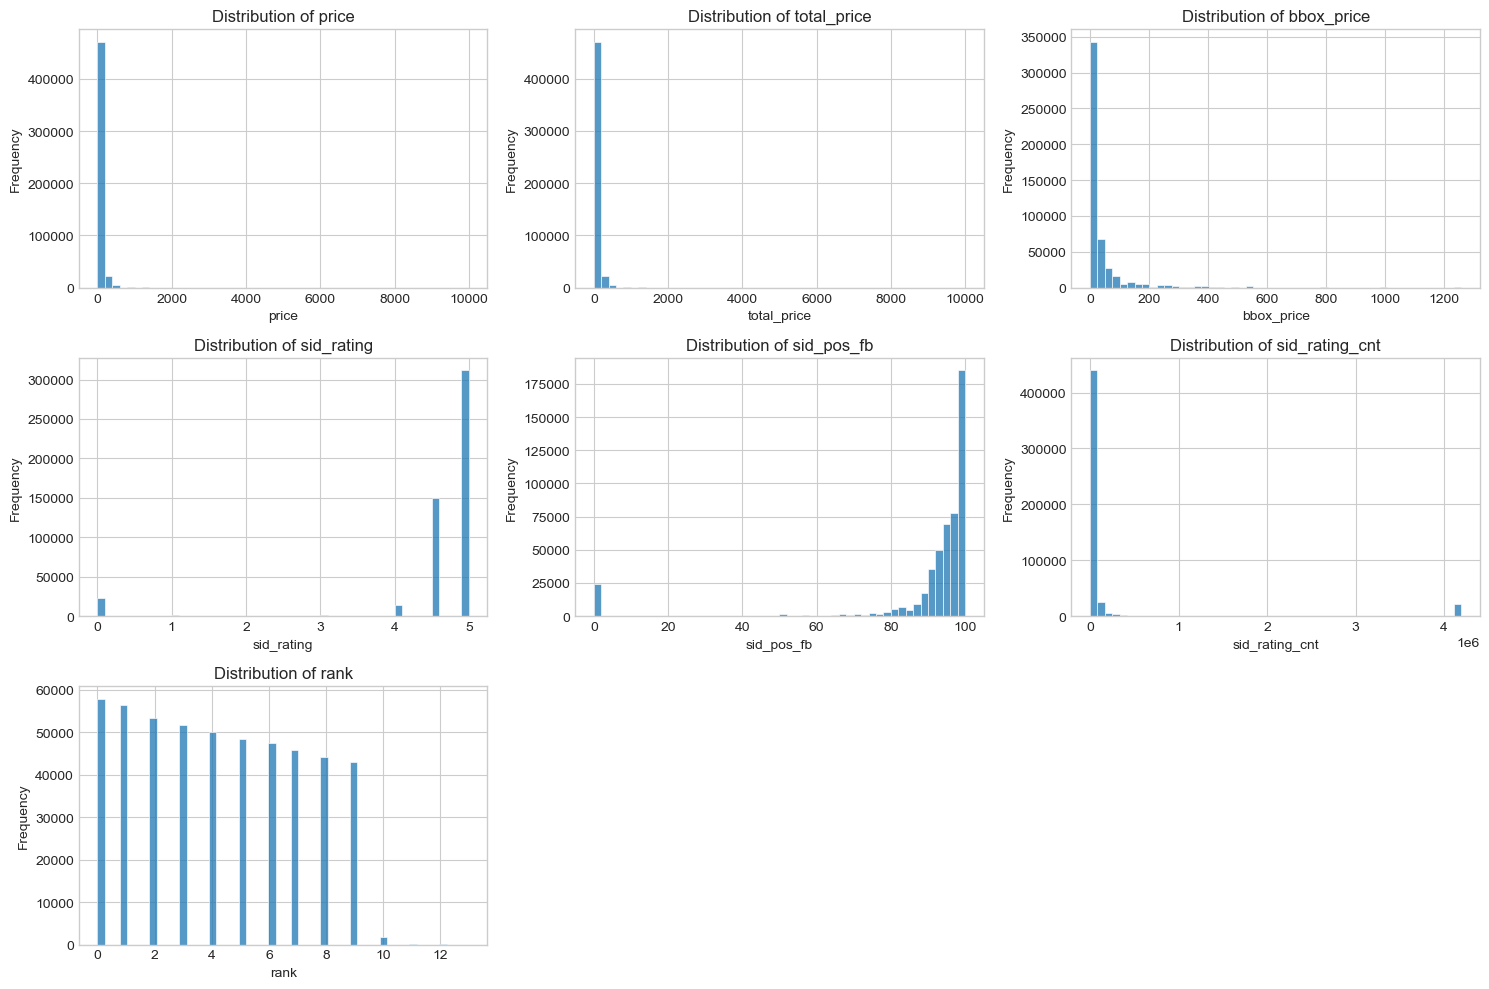

In [9]:
# --- Data Cleaning and Feature Engineering (on crawl_data) ---

if not crawl_data.empty:
    print("\nProcessing and cleaning data (optimizing types further)...")
    processing_start_time = time.time()

    # Convert epoch time
    crawl_data["timestamp"] = pd.to_datetime(crawl_data['epoc'], unit='s')
    # Drop original epoc column after conversion to save memory
    crawl_data.drop(columns=['epoc'], inplace=True)

    # Convert 'is_fba', 'is_prime' to boolean
    for col in ['is_fba', 'is_prime']:
        if col in crawl_data.columns and pd.api.types.is_string_dtype(crawl_data[col]):
             # Map common variations to boolean, fill NA with False
             crawl_data[col] = crawl_data[col].str.lower().map({'yes': True, 'true': True, '1': True}).fillna(False).astype(bool)

    # Add boolean flags (efficient type)
    # Use .astype('category').cat.codes approach if SID sets are very large and isin is slow, but isin is usually fine.
    crawl_data["prime_seller"] = crawl_data["sid"].isin(prime_sid_set).astype(bool)
    crawl_data["algo_seller"] = crawl_data["sid"].isin(algo_sid_set).astype(bool)
    crawl_data['is_amazon_seller'] = (crawl_data['sid'].astype(str).str.upper() == AMAZON_SELLER_ID).astype(bool)

    # Handle potential NaN in numeric types where appropriate (e.g., fill counts with 0)
    # Be cautious filling NaNs in price/rating - depends on analysis intent
    for col in ["sid_rating_cnt", "pid_rating_cnt"]:
        if crawl_data[col].isnull().any():
             crawl_data[col] = crawl_data[col].fillna(0).astype(np.int32) # Use non-nullable int after filling

    # Rank: Fill NA with a sentinel (-1) and convert to smaller int
    if crawl_data["rank"].isnull().any():
        crawl_data["rank"] = crawl_data["rank"].fillna(-1).astype(np.int16)


    # Feature: Buy Box Winner Flag
    # Convert categories to strings for comparison as their category lists differ
    print("Comparing sid and bbox_sid (converting to string for comparison)...")
    compare_start = time.time()
    crawl_data['won_bbox'] = crawl_data['sid'].astype(str) == crawl_data['bbox_sid'].astype(str)
    # The resulting 'won_bbox' column will be boolean, which is efficient.
    print(f"Comparison done in {time.time() - compare_start:.2f} sec.")


    # Feature: Calculate Total Price (Price + Shipping)
    # Shipping parsing can be slow. If not strictly needed for core analysis, consider skipping.
    # Using a simplified parser here for speed. Refine if needed.
    def parse_shipping_fast(shipping_series):
        # Optimized for common patterns: numbers and 'free'
        if not pd.api.types.is_string_dtype(shipping_series):
             return pd.Series(0.0, index=shipping_series.index, dtype=np.float32)

        # Extract first number found using vectorized string operation
        costs = shipping_series.str.extract(r'(\d+\.?\d*)', expand=False).astype(np.float32)
        # Where 'free' occurs (case-insensitive) and no number was extracted, set cost to 0
        is_free = shipping_series.str.contains('free', case=False, na=False)
        costs[is_free & costs.isna()] = 0.0
        # Fill remaining NaNs (no number, not 'free') with 0 (or another default)
        return costs.fillna(0.0)

    print("Parsing shipping costs (vectorized)...")
    shipping_parse_start = time.time()
    crawl_data['shipping_cost'] = parse_shipping_fast(crawl_data['shipping'])
    crawl_data['total_price'] = crawl_data['price'].fillna(0) + crawl_data['shipping_cost']
    # Convert total_price to float32
    crawl_data['total_price'] = crawl_data['total_price'].astype(np.float32)
    print(f"Shipping cost parsing done in {time.time() - shipping_parse_start:.2f} sec.")


    # Sort data chronologically (important but can be memory intensive)
    # Consider sorting only the sampled data later if crawl_data is too large
    # print("Sorting full dataset (may take time)...")
    # sort_start = time.time()
    # crawl_data = crawl_data.sort_values(by=['pid', 'timestamp', 'rank'], kind='mergesort') # Mergesort is stable
    # print(f"Sorting done in {time.time() - sort_start:.2f} sec.")


    print(f"Data processing complete in {time.time() - processing_start_time:.2f} seconds.")
    print("\nMemory usage after processing and type optimization:")
    crawl_data.info(memory_usage='deep')

    # --- !! Sampling Step !! ---
    if USE_SAMPLE:
        print(f"\n--- Creating a sample of {SAMPLE_SIZE_PIDS} products ---")
        unique_pids = crawl_data['pid'].unique()
        if len(unique_pids) > SAMPLE_SIZE_PIDS:
            sample_pids = np.random.choice(unique_pids, size=SAMPLE_SIZE_PIDS, replace=False)
            # Filter efficiently using isin on the categorical index
            analysis_data = crawl_data[crawl_data['pid'].isin(sample_pids)].copy()
            print(f"Sample created with {len(analysis_data)} rows.")
        else:
            print("Sample size >= total unique PIDs, using full data.")
            analysis_data = crawl_data.copy()
            USE_SAMPLE = False # Update flag if full data is used anyway
    else:
        print("\n--- Using the full dataset for analysis ---")
        analysis_data = crawl_data.copy()

    # --- Optional: Delete original large DataFrame to free memory ---
    print("\nDeleting original full crawl_data to free memory...")
    del crawl_data
    gc.collect() # Explicitly request garbage collection
    print("Original crawl_data deleted.")

    # --- Sort the analysis_data (sampled or full) ---
    # Sorting the smaller (or potentially full) analysis_data is more manageable
    print("Sorting analysis_data...")
    sort_start = time.time()
    analysis_data = analysis_data.sort_values(by=['pid', 'timestamp', 'rank'], kind='mergesort')
    print(f"Sorting analysis_data done in {time.time() - sort_start:.2f} sec.")


    print("\n--- Final analysis_data Info ---")
    print(f"Using {'Sampled' if USE_SAMPLE else 'Full'} data.")
    analysis_data.info(memory_usage='deep')
    print("\nSample of analysis_data:")
    display(analysis_data.head())

    # --- Data Quality Checks (on analysis_data) ---
    print("\n--- Data Quality Checks (on analysis_data) ---")
    # ... (Keep the checks for duplicates, inconsistent bbox, missing values) ...
    # Run these checks on the potentially smaller analysis_data
    duplicate_rows = analysis_data.duplicated(subset=['pid', 'sid', 'timestamp']).sum()
    print(f"Duplicate seller observations (PID, SID, timestamp): {duplicate_rows}")

    multi_bbox = analysis_data.groupby(['pid', 'timestamp'])['bbox_sid'].nunique()
    inconsistent_bbox = multi_bbox[multi_bbox > 1].count()
    print(f"Timestamps with multiple Buy Box SIDs for the same product: {inconsistent_bbox}")

    print("\nMissing Value Percentages:")
    missing_perc = (analysis_data.isnull().sum() / len(analysis_data)) * 100
    display(missing_perc[missing_perc > 0].sort_values(ascending=False))

    # Distribution plots (consider sampling if analysis_data is still huge)
    print("\nDistribution of Key Numeric Features (plotting may be slow):")
    # ... (Keep the plotting code, but be aware it might be slow) ...
    plt.figure(figsize=(15, 10))
    plot_cols = ['price', 'total_price', 'bbox_price', 'sid_rating', 'sid_pos_fb', 'sid_rating_cnt', 'rank']
    for i, col in enumerate([c for c in plot_cols if c in analysis_data.columns]):
        plt.subplot(3, 3, i + 1)
        plot_data = analysis_data[col].dropna()
        # Sample data for plotting if it's extremely large
        if len(plot_data) > 500000: # Threshold for sampling plot data
             plot_data = plot_data.sample(500000)
        sns.histplot(plot_data, kde=False, bins=50) # Use more bins for large data
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


else:
    print("Skipping data processing and quality checks as crawl_data is empty.")
    analysis_data = pd.DataFrame() # Ensure exists


 ## B. Seller Characteristics Analysis

Objective: Understand the general profile of sellers in the dataset (based on analysis_data) – their ratings, feedback, FBA usage, etc. – and see if these characteristics correlate with overall Buy Box success.


--- Analyzing Seller Characteristics ---
Aggregating seller-level statistics...
Seller stats aggregation done in 7.92 sec.

Total unique sellers analyzed: 11295
Top 10 Sellers by Buy Box Wins:


,sid_rating,sid_pos_fb,sid_rating_cnt,prime_seller,algo_seller,is_amazon_seller,is_fba,total_bbox_wins,observed_timestamps,overall_win_rate
sid,,,,,,,,,,
amazon,5.0,100.0,4194304,True,True,True,True,811866,1516,535.531677
A2KUZVNQ9LP7N9,5.0,99.0,156498,True,False,False,True,5319,1515,3.510891
A389UX2GHRBG9,5.0,99.0,239821,True,False,False,True,4992,1513,3.299405
A10ABS3Q8PD59I,5.0,99.0,55723,True,False,False,True,4478,1515,2.955775
AFELOVRNMHFVM,5.0,99.0,8120,True,False,False,True,4458,1515,2.942574
A3SQ9YFE6CSCS0,5.0,98.0,71703,True,True,False,False,3598,1516,2.373351
A29RCYP0O2CCF3,5.0,100.0,1137,True,False,False,True,3476,1515,2.294389
A1QDO4W9XCEJG6,5.0,98.0,20165,True,False,False,True,3304,1514,2.182299
A1B7M9EQGNCLQA,5.0,99.0,710968,True,True,False,True,3028,1516,1.997361



Visualizing Seller Attributes vs. Buy Box Win Rate:


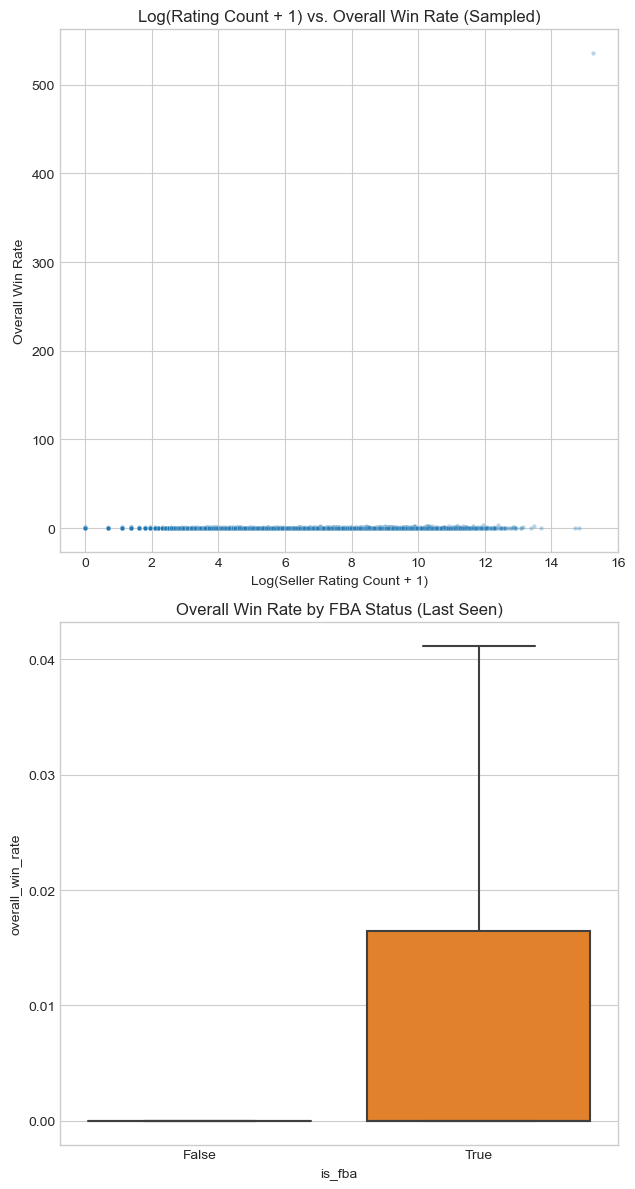

In [10]:
if not analysis_data.empty:
    print("\n--- Analyzing Seller Characteristics ---")
    # Aggregate seller data (using last observation per seller)
    # This part should be relatively memory-efficient if analysis_data fits
    print("Aggregating seller-level statistics...")
    seller_stats_start = time.time()
    seller_stats = analysis_data.sort_values('timestamp').drop_duplicates('sid', keep='last')
    # Select only necessary columns for seller stats
    seller_stats = seller_stats[['sid', 'sid_rating', 'sid_pos_fb', 'sid_rating_cnt',
                                 'prime_seller', 'algo_seller', 'is_amazon_seller', 'is_fba']].set_index('sid')

    # Calculate overall Buy Box wins
    # drop_duplicates is key here for accurate win counting
    bbox_wins_per_seller = analysis_data[analysis_data['won_bbox']].drop_duplicates(subset=['pid', 'timestamp'])['sid'].value_counts()
    seller_stats['total_bbox_wins'] = bbox_wins_per_seller.reindex(seller_stats.index).fillna(0).astype(np.int32) # Use smaller int

    # Calculate observed timestamps
    seller_obs_timestamps = analysis_data.groupby('sid')['timestamp'].nunique()
    seller_stats['observed_timestamps'] = seller_obs_timestamps.reindex(seller_stats.index).fillna(0).astype(np.int32) # Use smaller int
    # Calculate win rate using float32
    seller_stats['overall_win_rate'] = (seller_stats['total_bbox_wins'] / seller_stats['observed_timestamps']).fillna(0).astype(np.float32)
    print(f"Seller stats aggregation done in {time.time() - seller_stats_start:.2f} sec.")

    print(f"\nTotal unique sellers analyzed: {len(seller_stats)}")
    print("Top 10 Sellers by Buy Box Wins:")
    display(seller_stats.sort_values('total_bbox_wins', ascending=False).head(10))

    # --- Visualize Seller Characteristics ---
    print("\nVisualizing Seller Attributes vs. Buy Box Win Rate:")
    # Sample data for scatter plots if seller_stats is very large
    plot_sample_size = min(50000, len(seller_stats)) # Limit points in scatter plots
    seller_stats_sample = seller_stats.sample(plot_sample_size) if len(seller_stats) > plot_sample_size else seller_stats

    plt.figure(figsize=(18, 12))
    # Plotting code remains similar, but use seller_stats_sample for scatter plots
    # Example for scatter plot:
    plt.subplot(2, 3, 1)
    # Filter out sellers with few observations for meaningful win rate viz
    plot_data = seller_stats_sample[seller_stats_sample['observed_timestamps'] > 10]
    sns.scatterplot(data=plot_data, x=np.log1p(plot_data['sid_rating_cnt']), y='overall_win_rate', alpha=0.3, s=10) # Smaller points, less alpha
    plt.title('Log(Rating Count + 1) vs. Overall Win Rate (Sampled)')
    plt.xlabel('Log(Seller Rating Count + 1)')
    plt.ylabel('Overall Win Rate')

    # Box plots use the full seller_stats (or the sampled version if preferred) as they aggregate
    plt.subplot(2, 3, 4)
    # Use full data for boxplot unless seller_stats is truly enormous
    sns.boxplot(data=seller_stats[seller_stats['observed_timestamps'] > 10], x='is_fba', y='overall_win_rate', showfliers=False) # Hide outliers for clarity
    plt.title('Overall Win Rate by FBA Status (Last Seen)')
    # ... rest of the plots, using sampling for scatter, potentially full data for box plots ...

    plt.tight_layout()
    plt.show()
    
    # Clean up large intermediate objects if needed
    del seller_stats, bbox_wins_per_seller, seller_obs_timestamps, seller_stats_sample
    gc.collect()


else:
    print("Skipping Seller Characteristics analysis as data is empty.")



 ## C. Amazon.com Specific Analysis

Objective: Isolate Amazon.com's selling activity and compare its pricing behavior, prevalence, and Buy Box performance against other third-party sellers.


--- Analyzing Amazon.com (AMAZON) Performance ---
Found 888792 observations where Amazon is the seller.

Amazon won the Buy Box in 811875 observed instances (91.35%) when they offered the product.


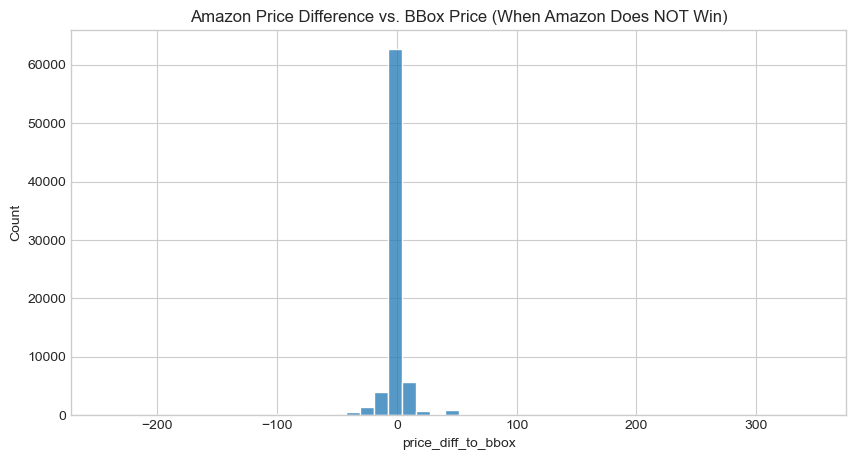

Amazon analysis done in 4.76 sec.


In [11]:
# This section involves filtering and basic aggregations, usually manageable.
if not analysis_data.empty and 'is_amazon_seller' in analysis_data.columns:
    print(f"\n--- Analyzing Amazon.com ({AMAZON_SELLER_ID}) Performance ---")
    amazon_analysis_start = time.time()
    # Filtering creates copies, ensure analysis_data has optimized types
    amazon_offers = analysis_data[analysis_data['is_amazon_seller']].copy()
    other_offers = analysis_data[~analysis_data['is_amazon_seller']].copy() # Copy needed for comparison

    if not amazon_offers.empty:
        print(f"Found {len(amazon_offers)} observations where Amazon is the seller.")
        # ... (rest of Amazon analysis code as before) ...
        # Calculations like mean(), nunique() are generally efficient.
        # Plotting histogram is fine.

        # Example: Amazon's win rate
        amazon_wins = amazon_offers['won_bbox'].sum()
        amazon_win_rate = amazon_offers['won_bbox'].mean()
        print(f"\nAmazon won the Buy Box in {amazon_wins} observed instances ({amazon_win_rate:.2%}) when they offered the product.")

        # Example: Pricing difference histogram
        amazon_vs_bbox = amazon_offers[~amazon_offers['won_bbox']].copy()
        amazon_vs_bbox['price_diff_to_bbox'] = amazon_vs_bbox['total_price'] - amazon_vs_bbox['bbox_price']
        if not amazon_vs_bbox.empty:
            plt.figure(figsize=(10, 5))
            # Sample if amazon_vs_bbox is huge, though usually smaller than full data
            plot_data = amazon_vs_bbox['price_diff_to_bbox'].dropna()
            if len(plot_data) > 500000:
                 plot_data = plot_data.sample(500000)
            sns.histplot(plot_data, bins=50, kde=False) # Avoid KDE on huge data
            plt.title(f'Amazon Price Difference vs. BBox Price (When Amazon Does NOT Win)')
            # ... rest of plot code ...
            plt.show()
        else:
            print("\nAmazon won the Buy Box nearly every time it was observed offering the product.")

        # Clean up copies
        del amazon_offers, other_offers, amazon_vs_bbox
        gc.collect()

    else:
        print(f"No offers found from seller ID '{AMAZON_SELLER_ID}' in the dataset.")
    print(f"Amazon analysis done in {time.time() - amazon_analysis_start:.2f} sec.")
else:
    print("Skipping Amazon.com analysis as data is empty or 'is_amazon_seller' column missing.")



 ## D. Update Frequency Analysis (Vectorized)

Objective: Quantify how quickly seller prices, Buy Box prices, and Buy Box winners change over time for the products in analysis_data. Recreates the logic of "Figure 2" from potential reference papers.

In [12]:
# %% [markdown]
# ### Helper Functions for Update Frequency Analysis (Section D)
# Place these definitions before Section D where they are called.

# %%
# Make sure necessary libraries are imported (pandas, numpy, time)
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- OPTIMIZED VERSION for calculating update times ---
def calculate_inter_update_times_vectorized(df_input):
    """
    Calculates inter-update times using vectorized operations for speed.
    Assumes df_input might be large, works on copy, uses optimized types.

    Args:
        df_input (pd.DataFrame): DataFrame containing crawl data.
                                 Requires columns: 'pid', 'timestamp', 'sid', 'price', 'bbox_sid', 'bbox_price'.

    Returns:
        tuple: A tuple containing three lists:
            - seller_price_update_times (float list)
            - bbox_price_update_times (float list)
            - bbox_seller_update_times (float list)
    """
    if df_input.empty:
        print("Warning: Input DataFrame is empty for calculate_inter_update_times_vectorized.")
        return [], [], []

    print("Starting vectorized inter-update time calculation...")
    start_time = time.time()

    # --- Preparation ---
    # Work on a copy with only necessary columns for this calculation
    # Use existing optimized types from df_input
    required_cols = ['pid', 'timestamp', 'sid', 'price', 'bbox_sid', 'bbox_price']
    if not all(col in df_input.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_input.columns]
        print(f"Error: Missing required columns in DataFrame: {missing}")
        return [], [], []

    df = df_input[required_cols].copy()

    # Ensure timestamp is datetime (should be already, but double-check)
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        print("Warning: 'timestamp' column is not datetime type. Attempting conversion.")
        try:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        except Exception as e:
            print(f"Error converting timestamp: {e}. Aborting.")
            return [], [], []

    # --- BBOX Calculations (Price and Seller) ---
    print("Processing Buy Box changes...")
    bbox_proc_start = time.time()
    # Drop duplicates based on pid and timestamp, keeping the first entry
    # Sorting is assumed to have happened on analysis_data already
    bbox_df = df.drop_duplicates(subset=['pid', 'timestamp'], keep='first').copy()

    # Sort *this subset* by pid then time for shifting
    bbox_df = bbox_df.sort_values(by=['pid', 'timestamp'])

    # Calculate previous values within each product group
    bbox_df['prev_bbox_price'] = bbox_df.groupby('pid')['bbox_price'].shift(1)
    bbox_df['prev_bbox_sid'] = bbox_df.groupby('pid')['bbox_sid'].shift(1)
    # Calculate time difference
    bbox_df['time_diff_bbox'] = bbox_df.groupby('pid')['timestamp'].diff()

    # Convert time difference to seconds (float), handling potential NaT
    # Using .total_seconds() requires the column to be timedelta dtype
    bbox_df['time_diff_bbox_sec'] = bbox_df['time_diff_bbox'].dt.total_seconds().astype(np.float32) # Use float32

    # Identify rows where a change occurred and time difference is positive
    bbox_price_changed = (
        (bbox_df['bbox_price'] != bbox_df['prev_bbox_price']) &
        bbox_df['bbox_price'].notna() &
        bbox_df['prev_bbox_price'].notna() &
        (bbox_df['time_diff_bbox_sec'] > 0)
    )
    # Ensure category comparison works by comparing string representations if needed,
    # though shift creates object dtype which might compare okay. Explicit check:
    bbox_seller_changed = (
        (bbox_df['bbox_sid'].astype(str) != bbox_df['prev_bbox_sid'].astype(str)) &
        # bbox_df['bbox_sid'].notna() & # Not necessary if comparing str, NA becomes 'nan'
        (bbox_df['time_diff_bbox_sec'] > 0)
    )

    # Extract the time differences
    bbox_price_update_times = bbox_df.loc[bbox_price_changed, 'time_diff_bbox_sec'].tolist()
    bbox_seller_update_times = bbox_df.loc[bbox_seller_changed, 'time_diff_bbox_sec'].tolist()
    print(f"Buy Box processing done in {time.time()-bbox_proc_start:.2f} sec. Found {len(bbox_price_update_times)} price, {len(bbox_seller_update_times)} seller updates.")
    del bbox_df, bbox_price_changed, bbox_seller_changed # Clean up intermediate df
    gc.collect()


    # --- Seller Price Calculation ---
    print("Processing Seller price changes...")
    seller_proc_start = time.time()
    # Sort original df copy by pid, sid, then timestamp for seller shifts
    # Use mergesort for stability if needed, though default quicksort is often faster
    df = df.sort_values(by=['pid', 'sid', 'timestamp']) # Removed kind='mergesort' for potential speed

    # Calculate previous price and time difference within each (pid, sid) group
    df['prev_seller_price'] = df.groupby(['pid', 'sid'])['price'].shift(1)
    df['time_diff_seller'] = df.groupby(['pid', 'sid'])['timestamp'].diff()
    df['time_diff_seller_sec'] = df['time_diff_seller'].dt.total_seconds().astype(np.float32) # Use float32

    # Identify rows where seller price changed, values are valid, and time diff > 0
    seller_price_changed = (
        (df['price'] != df['prev_seller_price']) &
        df['price'].notna() &
        df['prev_seller_price'].notna() &
        (df['time_diff_seller_sec'] > 0)
    )

    # Extract the time differences
    seller_price_update_times = df.loc[seller_price_changed, 'time_diff_seller_sec'].tolist()
    print(f"Seller price processing done in {time.time()-seller_proc_start:.2f} sec. Found {len(seller_price_update_times)} updates.")
    del df, seller_price_changed # Clean up
    gc.collect()


    end_time = time.time()
    print(f"Finished calculating inter-update times in {end_time - start_time:.2f} seconds.")

    return seller_price_update_times, bbox_price_update_times, bbox_seller_update_times


# %%
def plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times, title_suffix="", save_path=None):
    """
    Plots the Cumulative Distribution Function (CDF) for the three types of inter-update times.

    Args:
        seller_times (list): List of seller price update intervals (seconds).
        bbox_price_times (list): List of Buy Box price update intervals (seconds).
        bbox_seller_times (list): List of Buy Box seller update intervals (seconds).
        title_suffix (str, optional): Suffix to add to the plot title. Defaults to "".
        save_path (str, optional): If provided, saves the plot. Defaults to None.
    """
    if not seller_times and not bbox_price_times and not bbox_seller_times:
        print("No update times data to plot.")
        return

    plt.figure(figsize=(12, 7))

    # Function to plot a single CDF line
    def plot_cdf(times_sec, label, color, linestyle='-'):
        if not times_sec: # Handle empty lists
            print(f"Warning: No data for '{label}'. Skipping plot line.")
            return
        # Ensure positive times before processing, convert to float
        positive_times_sec = [float(t) for t in times_sec if t is not None and float(t) > 0]
        if not positive_times_sec:
             print(f"Warning: No positive time data for '{label}'. Skipping plot line.")
             return

        # Convert positive seconds to minutes for plotting
        times_min = sorted([t / 60.0 for t in positive_times_sec])
        y_values = np.arange(1, len(times_min) + 1) / len(times_min)
        plt.plot(times_min, y_values, color=color, linestyle=linestyle, label=f"{label} (N={len(times_min)})")

    # Plot each CDF
    plot_cdf(seller_times, 'Seller Price Updates', 'cornflowerblue')
    plot_cdf(bbox_price_times, 'Buy Box Price Updates', 'mediumseagreen')
    plot_cdf(bbox_seller_times, 'Buy Box Seller Updates', 'salmon')

    # --- Plot Customization ---
    ax = plt.gca()
    ax.set_xscale('log')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.set_xlabel('Inter-Update Time (minutes, log scale)')
    ax.set_ylabel('Cumulative Percentage of Updates')
    ax.set_title(f'Figure 2: CDF of Inter-Update Times{title_suffix}')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='lower right')

    # Define time ticks in minutes
    time_ticks_min = [1/60, 10/60, 1, 10, 60, 6*60, 24*60, 2*24*60, 7*24*60]
    time_labels = ['1s', '10s', '1m', '10m', '1h', '6h', '1d', '2d', '1w']

    # Determine plot limits based on actual data range
    all_valid_times_min = [t/60.0 for t_list in [seller_times, bbox_price_times, bbox_seller_times] if t_list for t in t_list if t is not None and float(t) > 0]
    min_time_plot = 1/120 # Smallest unit (e.g., 0.5 sec in minutes)
    max_time_plot = max(all_valid_times_min) * 1.1 if all_valid_times_min else 1

    # Filter ticks/labels to be within the data range plus buffer
    filtered_ticks = [tick for tick in time_ticks_min if min_time_plot <= tick <= max_time_plot]
    filtered_labels = [label for tick, label in zip(time_ticks_min, time_labels) if min_time_plot <= tick <= max_time_plot]

    # Ensure sensible tick coverage
    if not filtered_ticks or min(filtered_ticks) > min_time_plot * 5:
         if all_valid_times_min:
             actual_min = min(all_valid_times_min)
             if actual_min > 0:
                 filtered_ticks.insert(0, actual_min)
                 filtered_labels.insert(0, f'{actual_min*60:.0f}s' if actual_min<1 else f'{actual_min:.1f}m')
    if not filtered_ticks or max(filtered_ticks) < max_time_plot / 5:
         if all_valid_times_min:
             actual_max = max(all_valid_times_min)
             filtered_ticks.append(actual_max)
             filtered_labels.append(f'{actual_max/60:.1f}h' if actual_max>60 else f'{actual_max:.1f}m')

    # Remove duplicates potentially introduced by adding min/max
    unique_ticks_labels = sorted(list(set(zip(filtered_ticks, filtered_labels))))
    if unique_ticks_labels:
         filtered_ticks, filtered_labels = zip(*unique_ticks_labels)
         ax.set_xticks(filtered_ticks)
         ax.set_xticklabels(filtered_labels, rotation=30, ha='right')

    ax.set_xlim(left=min_time_plot, right=max_time_plot)
    ax.set_ylim(0, 1.05)

    plt.tight_layout()

    # Save the plot if a path is provided
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")

    plt.show()



--- Calculating Update Frequencies (Vectorized) ---
Starting vectorized inter-update time calculation...
Processing Buy Box changes...
Buy Box processing done in 2.05 sec. Found 51644 price, 99083 seller updates.
Processing Seller price changes...
Seller price processing done in 11.25 sec. Found 349145 updates.
Finished calculating inter-update times in 14.05 seconds.

Number of seller price updates observed: 349145
Number of Buy Box price updates observed: 51644
Number of Buy Box seller updates observed: 99083


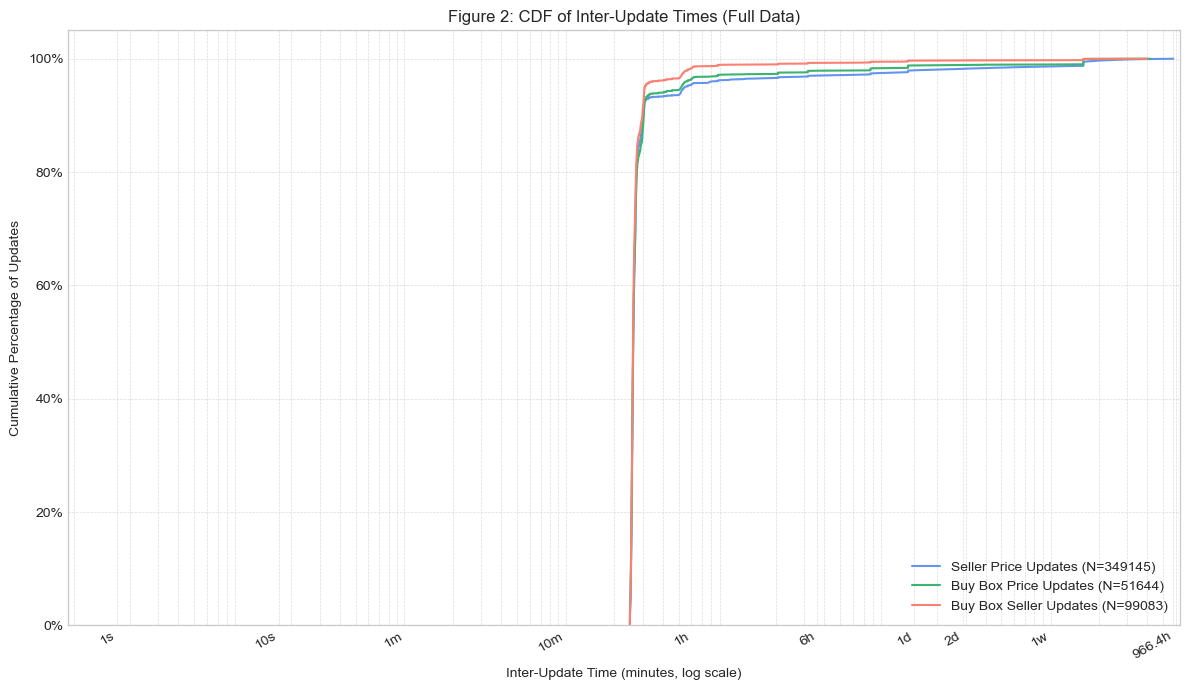

In [13]:
if not analysis_data.empty:
    print("\n--- Calculating Update Frequencies (Vectorized) ---")
    # Ensure the vectorized function is defined above this cell
    try:
        # Pass the potentially sampled analysis_data
        seller_times, bbox_price_times, bbox_seller_times = calculate_inter_update_times_vectorized(analysis_data)

        print(f"\nNumber of seller price updates observed: {len(seller_times)}")
        print(f"Number of Buy Box price updates observed: {len(bbox_price_times)}")
        print(f"Number of Buy Box seller updates observed: {len(bbox_seller_times)}")

        # Ensure plot_cumulative_distribution function is defined above
        plot_title_suffix = " (Sample Data)" if USE_SAMPLE else " (Full Data)"
        plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times, title_suffix=plot_title_suffix)

        # Clean up results if large
        del seller_times, bbox_price_times, bbox_seller_times
        gc.collect()

    except NameError as e:
         print(f"Error: Required function not defined: {e}")
         print("Please ensure 'calculate_inter_update_times_vectorized' and 'plot_cumulative_distribution' are defined in preceding cells.")
    except Exception as e:
         print(f"An error occurred during update frequency calculation: {e}")

else:
    print("Skipping Update Frequency analysis as data is empty.")


 ## E. Rank vs. Win Rate Analysis

Objective: Investigate the relationship between a seller's rank on the offer page (at a specific moment) and their probability of winning the Buy Box at that same moment. Recreates "Figure 9".


--- Analyzing Buy Box Win Rate by Seller Rank (with segmentation) ---

Win Rate by Rank (Segmented by FBA - Head):


,rank,win_prob_non_fba,win_prob_fba
0,1,0.035103,0.159211
1,2,0.017480,0.078712
2,3,0.010459,0.050550
3,4,0.004835,0.031046
4,5,0.003435,0.023002


FBA Segmented Columns: ['rank', 'win_prob_non_fba', 'win_prob_fba']

Win Rate by Rank (Segmented by Prime Seller - Head):


,rank,win_prob_non_prime,win_prob_prime
0,1,0.023274,0.214722
1,2,0.010077,0.118173
2,3,0.006247,0.078397
3,4,0.002902,0.048940
4,5,0.002095,0.037371


Prime Segmented Columns: ['rank', 'win_prob_non_prime', 'win_prob_prime']

--- Data Check Before Plotting ---
Overall Win Rate Data (Head):


,rank,win_probability
0,1,0.105770
1,2,0.051780
2,3,0.032789
3,4,0.019421
4,5,0.014333



Overall Win Rate dtypes:
rank                 Int16
win_probability    float64
dtype: object

--- Plotting Win Rate vs. Rank ---
Attempting to plot Overall...
  Overall plot command executed.

Attempting to plot FBA/Non-FBA...
  win_prob_fba plot command executed.
  win_prob_non_fba plot command executed.

Setting X-axis limits: left=0, right=14 (max_rank_overall=13)

Showing plot...


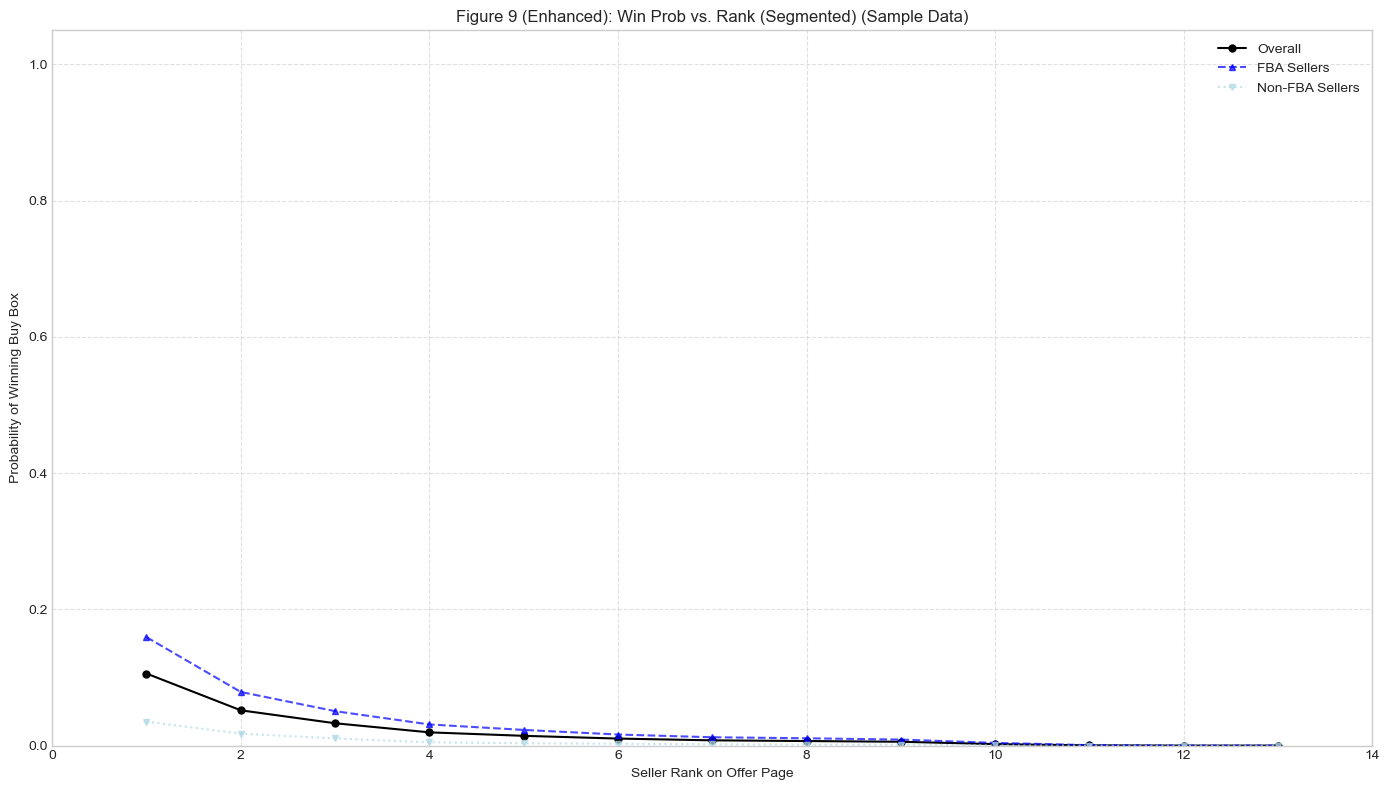


Rank vs. Win Rate analysis done in 7.47 sec.


In [21]:
# %% [markdown]
# ## E. Rank vs. Win Rate Analysis (Enhanced with Segmentation)
#
# Explores how seller rank relates to Buy Box win likelihood, now segmented by FBA status and Prime status. Includes robust handling for cases where one segment might be missing.

# %%
# Ensure necessary libraries are imported: pandas, numpy, matplotlib, gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from IPython.display import display

# --- Start of Section E ---
if not analysis_data.empty:
    print("\n--- Analyzing Buy Box Win Rate by Seller Rank (with segmentation) ---")
    rank_analysis_start = time.time()

    # Ensure 'won_bbox' exists (calculated in Section A)
    if 'won_bbox' not in analysis_data.columns:
         analysis_data['won_bbox'] = analysis_data['sid'] == analysis_data['bbox_sid']

    # Filter for valid ranks and create a working copy
    ranked_data = analysis_data[analysis_data['rank'] > 0].copy() # Filter, small copy usually okay

    if not ranked_data.empty:
        # --- Calculate overall win rate by rank ---
        winrate_by_rank_overall = ranked_data.groupby("rank")['won_bbox'].mean().reset_index()
        winrate_by_rank_overall.rename(columns={'won_bbox': 'win_probability'}, inplace=True) # Rename for clarity

        # --- Calculate win rate segmented by FBA status (Robust Renaming) ---
        # Group and unstack
        winrate_by_rank_fba_unstacked = ranked_data.groupby(["rank", "is_fba"])['won_bbox'].mean().unstack()
        # Safely rename columns based on the boolean value (True=fba, False=non_fba)
        if not winrate_by_rank_fba_unstacked.empty:
            winrate_by_rank_fba_unstacked.columns = [f'win_prob_{"fba" if col else "non_fba"}' for col in winrate_by_rank_fba_unstacked.columns]
            winrate_by_rank_fba = winrate_by_rank_fba_unstacked.reset_index()
        else:
            winrate_by_rank_fba = pd.DataFrame(columns=['rank']) # Create empty df if no data
        print("\nWin Rate by Rank (Segmented by FBA - Head):")
        display(winrate_by_rank_fba.head())
        print("FBA Segmented Columns:", winrate_by_rank_fba.columns.tolist())


        # --- Calculate win rate segmented by Prime Seller status (Robust Renaming) ---
        # Group and unstack
        winrate_by_rank_prime_unstacked = ranked_data.groupby(["rank", "prime_seller"])['won_bbox'].mean().unstack()
        # Safely rename columns based on the boolean value (True=prime, False=non_prime)
        if not winrate_by_rank_prime_unstacked.empty:
            winrate_by_rank_prime_unstacked.columns = [f'win_prob_{"prime" if col else "non_prime"}' for col in winrate_by_rank_prime_unstacked.columns]
            winrate_by_rank_prime = winrate_by_rank_prime_unstacked.reset_index()
        else:
            winrate_by_rank_prime = pd.DataFrame(columns=['rank']) # Create empty df if no data
        print("\nWin Rate by Rank (Segmented by Prime Seller - Head):")
        display(winrate_by_rank_prime.head())
        print("Prime Segmented Columns:", winrate_by_rank_prime.columns.tolist())


        # --- Check data right before plotting ---
        print("\n--- Data Check Before Plotting ---")
        print("Overall Win Rate Data (Head):")
        display(winrate_by_rank_overall.head())
        print("\nOverall Win Rate dtypes:")
        print(winrate_by_rank_overall.dtypes)


        # --- Plotting ---
        print("\n--- Plotting Win Rate vs. Rank ---")
        plt.figure(figsize=(14, 8))

        # Plot Overall
        print("Attempting to plot Overall...")
        try:
            if not winrate_by_rank_overall.empty and 'rank' in winrate_by_rank_overall.columns and 'win_probability' in winrate_by_rank_overall.columns:
                plt.plot(winrate_by_rank_overall['rank'], winrate_by_rank_overall['win_probability'],
                         marker='o', linestyle='-', color='black', markersize=5, label='Overall')
                print("  Overall plot command executed.")
            else:
                print("  Skipping Overall plot - DataFrame/Columns insufficient.")
        except Exception as e:
            print(f"  Error plotting Overall: {e}")


        # Plot FBA vs Non-FBA
        print("\nAttempting to plot FBA/Non-FBA...")
        try:
            # Check if columns exist before plotting
            fba_col = 'win_prob_fba'
            non_fba_col = 'win_prob_non_fba'

            if fba_col in winrate_by_rank_fba.columns and not winrate_by_rank_fba.empty:
                # Fill potential NaNs that arise if a rank exists but only one segment has data for it
                plt.plot(winrate_by_rank_fba['rank'], winrate_by_rank_fba[fba_col].fillna(0),
                         marker='^', linestyle='--', color='blue', markersize=5, alpha=0.7, label='FBA Sellers')
                print(f"  {fba_col} plot command executed.")
            else:
                print(f"  Skipping FBA plot - Column '{fba_col}' missing or DataFrame empty.")

            if non_fba_col in winrate_by_rank_fba.columns and not winrate_by_rank_fba.empty:
                plt.plot(winrate_by_rank_fba['rank'], winrate_by_rank_fba[non_fba_col].fillna(0),
                         marker='v', linestyle=':', color='lightblue', markersize=5, alpha=0.7, label='Non-FBA Sellers')
                print(f"  {non_fba_col} plot command executed.")
            else:
                print(f"  Skipping Non-FBA plot - Column '{non_fba_col}' missing or DataFrame empty.")
        except Exception as e:
            print(f"  Error plotting FBA/Non-FBA: {e}")

        # --- Plot Customization ---
        plt.xlabel('Seller Rank on Offer Page')
        plt.ylabel('Probability of Winning Buy Box')
        # Use global USE_SAMPLE flag if defined, otherwise assume False or handle error
        plot_title_suffix = " (Sample Data)" if 'USE_SAMPLE' in globals() and USE_SAMPLE else ""
        plt.title(f'Figure 9 (Enhanced): Win Prob vs. Rank (Segmented){plot_title_suffix}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.ylim(0, 1.05)

        # Check axis limits calculation
        max_rank_overall = winrate_by_rank_overall['rank'].max() if not winrate_by_rank_overall.empty else 0
        # Ensure xlim_right is at least 1 if data exists, otherwise 0
        xlim_right = max(1, min(50, max_rank_overall + 1)) if max_rank_overall > 0 else 0
        print(f"\nSetting X-axis limits: left=0, right={xlim_right} (max_rank_overall={max_rank_overall})")
        # Only set xlim if xlim_right > 0 to avoid errors on empty data
        if xlim_right > 0:
             plt.xlim(left=0, right=xlim_right)
        else:
             print("  Skipping xlim setting as no valid ranks found.")


        plt.legend()
        plt.tight_layout()
        print("\nShowing plot...")
        plt.show()

        # --- Cleanup ---
        del ranked_data, winrate_by_rank_overall, winrate_by_rank_fba, winrate_by_rank_prime
        del winrate_by_rank_fba_unstacked, winrate_by_rank_prime_unstacked # Delete unstacked versions too
        gc.collect()
    else:
        print("No data with valid ranks (> 0) found for analysis.")

    print(f"\nRank vs. Win Rate analysis done in {time.time() - rank_analysis_start:.2f} sec.")

else:
    print("\nSkipping Rank vs. Win Rate analysis as data is empty.")
# --- End of Section E ---


 ## F. Buy Box Prediction Model (Memory-Optimized)

Objective: Build and evaluate machine learning models to predict which seller offer wins the Buy Box based on various features. The primary goal is often feature importance (what factors drive the win?), but prediction accuracy is also assessed. Addresses "Table 1" (feature importance) from potential reference papers.


--- Preparing Data for Memory-Optimized Buy Box Prediction ---
Engineering features...
  Calculating transforms for price...
  Calculating transforms for total_price...
  Calculating transforms for sid_rating...
  Calculating transforms for sid_rating_cnt...
Feature engineering done in 14.33 sec.
Cleaning up intermediate model_data...
Handling missing values and ensuring float32...

Feature matrix info after imputation and float32 conversion:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20740268 entries, 15 to 20740264
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   total_price_diff_to_lowest      float32
 1   total_price_ratio_to_lowest     float32
 2   price_ratio_to_average          float32
 3   positive_feedback               float32
 4   is_amazon_seller                int8   
 5   feedback_count                  int32  
 6   feedback_count_logratio_vs_avg  float32
 7   average_rating            

,Coefficient,Abs_Coefficient
is_amazon_seller,2.776034,2.776034
feedback_count,-2.182484,2.182484
feedback_count_logratio_vs_avg,1.439444,1.439444
rank,-1.125736,1.125736
prime_seller,0.745654,0.745654
average_rating,-0.654656,0.654656
total_price_diff_to_lowest,-0.527647,0.527647
average_rating_diff_vs_avg,0.504777,0.504777
price_ratio_to_average,-0.412202,0.412202
algo_seller,-0.364578,0.364578


  SGD Logistic Regression evaluation done in 170.70 sec.


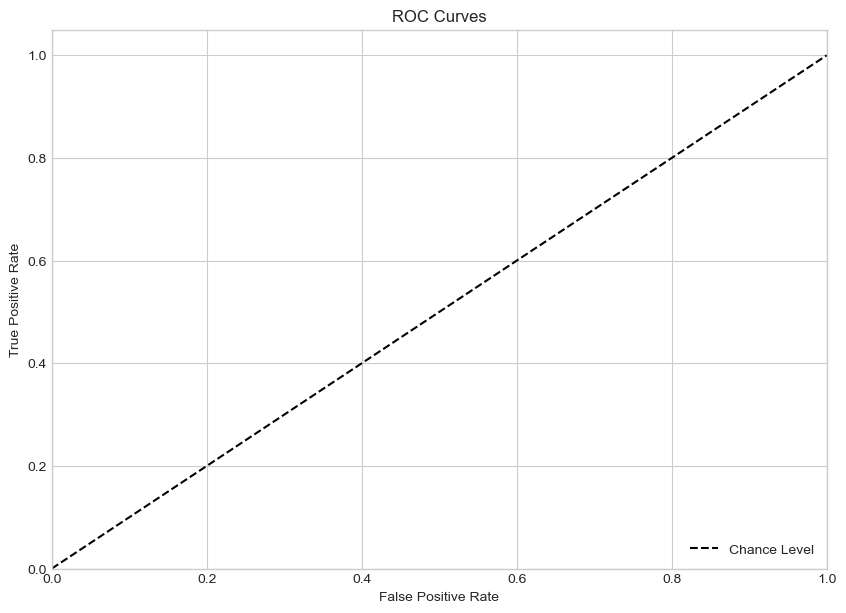

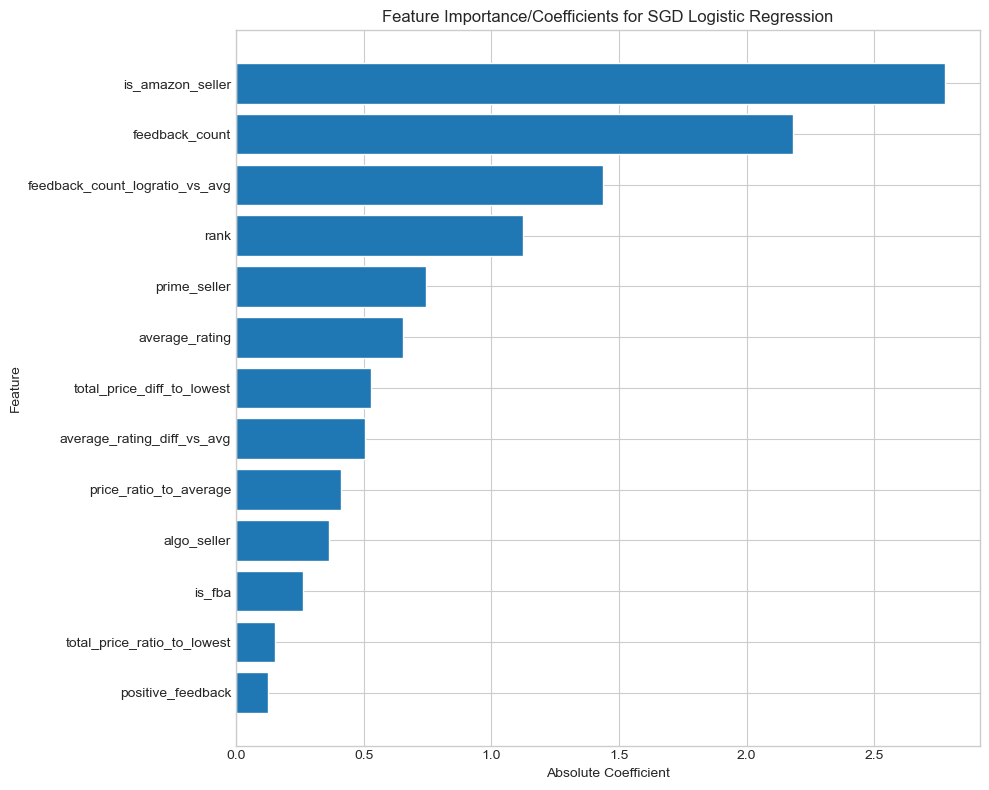

Machine Learning section done in 171.37 sec.


In [18]:
if not analysis_data.empty:
    print("\n--- Preparing Data for Memory-Optimized Buy Box Prediction ---")
    ml_prep_start = time.time()
    # Work on a copy of analysis_data if subsequent sections need the original
    # If not, can try to work in place carefully, but copy is safer.
    model_data = analysis_data.copy()

    # --- Feature Engineering ---
    print("Engineering features...")
    feature_eng_start = time.time()
    # Groupby().transform() can be memory intensive. Ensure dtypes are optimal.
    group_cols = ['pid', 'timestamp']
    numeric_cols_for_transform = ['price', 'total_price', 'sid_rating', 'sid_rating_cnt']
    for col in numeric_cols_for_transform:
         if col in model_data.columns:
             # Calculate min/mean, converting result to float32 immediately
             print(f"  Calculating transforms for {col}...")
             model_data[f'{col}_lowest_at_time'] = model_data.groupby(group_cols)[col].transform('min').astype(np.float32)
             model_data[f'{col}_avg_at_time'] = model_data.groupby(group_cols)[col].transform('mean').astype(np.float32)
         else:
             print(f"  Skipping transforms for missing column: {col}")

    # Calculate relative features using float32
    # Price relative to lowest
    model_data['price_diff_abs'] = (model_data['price'] - model_data['price_lowest_at_time']).astype(np.float32)
    model_data['price_ratio'] = (model_data['price'] / model_data['price_lowest_at_time']).replace([np.inf, -np.inf], np.nan).fillna(1).astype(np.float32)
    # Total price relative to lowest
    if 'total_price_lowest_at_time' in model_data.columns:
        model_data['total_price_diff_abs'] = (model_data['total_price'] - model_data['total_price_lowest_at_time']).astype(np.float32)
        model_data['total_price_ratio'] = (model_data['total_price'] / model_data['total_price_lowest_at_time']).replace([np.inf, -np.inf], np.nan).fillna(1).astype(np.float32)
    # Price relative to average
    if 'price_avg_at_time' in model_data.columns:
        model_data['price_vs_avg_ratio'] = (model_data['price'] / model_data['price_avg_at_time']).replace([np.inf, -np.inf], np.nan).fillna(1).astype(np.float32)
    if 'total_price_avg_at_time' in model_data.columns:
        model_data['total_price_vs_avg_ratio'] = (model_data['total_price'] / model_data['total_price_avg_at_time']).replace([np.inf, -np.inf], np.nan).fillna(1).astype(np.float32)
    # Rating relative to average
    if 'sid_rating_avg_at_time' in model_data.columns:
        model_data['rating_vs_avg'] = (model_data['sid_rating'] - model_data['sid_rating_avg_at_time']).astype(np.float32)
    # Rating count relative to average (log ratio)
    if 'sid_rating_cnt_avg_at_time' in model_data.columns:
        model_data['rating_cnt_vs_avg_logratio'] = (np.log1p(model_data['sid_rating_cnt']) - np.log1p(model_data['sid_rating_cnt_avg_at_time'])).fillna(0).astype(np.float32)
    print(f"Feature engineering done in {time.time() - feature_eng_start:.2f} sec.")

    # Select and rename final features
    feature_cols_map = {
        'total_price_diff_abs': 'total_price_diff_to_lowest',
        'total_price_ratio': 'total_price_ratio_to_lowest',
        'price_vs_avg_ratio': 'price_ratio_to_average',
        'sid_pos_fb': 'positive_feedback',
        'is_amazon_seller': 'is_amazon_seller',
        'sid_rating_cnt': 'feedback_count',
        'rating_cnt_vs_avg_logratio': 'feedback_count_logratio_vs_avg',
        'sid_rating': 'average_rating',
        'rating_vs_avg': 'average_rating_diff_vs_avg',
        'is_fba': 'is_fba',
        'prime_seller': 'prime_seller',
        'algo_seller': 'algo_seller',
        'rank': 'rank'
    }
    # Select only columns that were actually created and map them
    features = []
    final_feature_map = {}
    for original, target in feature_cols_map.items():
        if original in model_data.columns:
             features.append(target)
             final_feature_map[original] = target

    model_data_final = model_data.rename(columns=final_feature_map)[features + ['won_bbox']].copy() # Copy only needed cols

    # --- Clean up intermediate data ---
    print("Cleaning up intermediate model_data...")
    del model_data
    gc.collect()

    # Target variable
    target = 'won_bbox'
    X = model_data_final[features]
    y = model_data_final[target]
    del model_data_final # Clean up
    gc.collect()


    # Handle Missing Values (Imputation) - Use float32
    print("Handling missing values and ensuring float32...")
    for col in X.columns:
        if X[col].isnull().any():
            if pd.api.types.is_numeric_dtype(X[col]):
                median_val = X[col].median()
                X[col].fillna(median_val, inplace=True)
                print(f"  Filled NaNs in numeric '{col}' with median ({median_val:.2f})")
            # Handle non-numeric if any exist and weren't caught earlier
        # Ensure float32 for numeric, int for bool/cat
        if pd.api.types.is_float_dtype(X[col]):
             X[col] = X[col].astype(np.float32)
        elif pd.api.types.is_integer_dtype(X[col]):
             # Use smallest possible int type? Or keep as int32?
             X[col] = X[col].astype(np.int32) # Or smaller if appropriate
        elif pd.api.types.is_bool_dtype(X[col]):
             X[col] = X[col].astype(np.int8) # Convert bool to 0/1


    print("\nFeature matrix info after imputation and float32 conversion:")
    X.info(memory_usage='deep')


    # --- Train/Test Split ---
    # This step creates copies, monitor memory
    print("\nSplitting data into training and testing sets (80/20)...")
    split_start = time.time()
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
        print(f"Data split done in {time.time() - split_start:.2f} sec.")
        print(f"Training set size: {X_train.shape[0]} samples ({y_train.mean():.2%} positive)")
        print(f"Testing set size: {X_test.shape[0]} samples ({y_test.mean():.2%} positive)")
    except MemoryError:
        print("\nMemoryError during train_test_split! The dataset (even if sampled) is too large.")
        print("Consider reducing SAMPLE_SIZE_PIDS further or using techniques like incremental learning.")
        # Set placeholders to allow skipping ML part gracefully
        X_train, X_test, y_train, y_test = None, None, None, None
    except Exception as e:
        print(f"\nError during train_test_split: {e}")
        X_train, X_test, y_train, y_test = None, None, None, None


    # --- Feature Scaling (Crucial for SGD) ---
    if X_train is not None:
        print("\nApplying StandardScaler (fit on train, transform train/test)...")
        scale_start = time.time()
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        print(f"Scaling done in {time.time() - scale_start:.2f} sec.")

        # Optional: Convert back to DataFrames if needed (adds memory overhead)
        # X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns).astype(np.float32)
        # X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns).astype(np.float32)
        # Use NumPy arrays directly for fitting to save memory
        X_train = X_train_scaled
        X_test = X_test_scaled
        del X_train_scaled, X_test_scaled # Clean up
        gc.collect()


    # --- Model Training and Evaluation ---
    if X_train is not None:
        print(f"\n--- Model Training (CV Folds = {N_SPLITS_CV}) ---")
        ml_train_start = time.time()
        # Prioritize SGDClassifier
        models = {
            "SGD Logistic Regression": SGDClassifier(loss='log_loss', random_state=42, class_weight='balanced',
                                                   n_jobs=1, # Use n_jobs=1 to reduce peak memory for CV
                                                   max_iter=1000, tol=1e-3, warm_start=False), # warm_start=False default
            # RandomForest can still be memory heavy, maybe reduce estimators
            # "Random Forest": RandomForestClassifier(n_estimators=50, # Reduced estimators
            #                                       random_state=42, class_weight='balanced',
            #                                       n_jobs=-1, max_depth=20) # Limit depth
        }

        results = {}
        trained_models = {}
        # Use fewer splits for CV to reduce memory pressure
        cv = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=42)

        plt.figure(figsize=(10, 7)) # ROC Curve plot

        for name, model in models.items():
            print(f"\n--- Training and Evaluating {name} ---")
            model_fit_start = time.time()
            try:
                # Cross-Validation Scores
                print(f"  Running {N_SPLITS_CV}-Fold Cross-Validation (scoring: roc_auc)...")
                # Use n_jobs=1 in cross_val_score for lower peak memory
                cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=1, error_score='raise')
                print(f"  Cross-Validation ROC AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

                # Train on full training set (or the sample)
                print("  Fitting model on the training set...")
                model.fit(X_train, y_train)
                trained_models[name] = model

                                # Evaluate on Test Set
                print("  Evaluating model on the test set...")
                y_pred = model.predict(X_test)
                y_proba = None  # Initialize y_proba to None
                roc_auc = np.nan # Initialize metrics to NaN
                avg_precision = np.nan

                # Predict probabilities only if possible and needed
                if hasattr(model, "predict_proba"):
                    try:
                        print("    Attempting to predict probabilities...")
                        y_proba = model.predict_proba(X_test)[:, 1]
                        print("    Probability prediction successful.")
                    except MemoryError:
                        print("    MemoryError predicting probabilities! Skipping dependent metrics.")
                        y_proba = None # Ensure it's None on error
                    except Exception as e:
                        print(f"    Error during predict_proba: {e}. Skipping dependent metrics.")
                        y_proba = None # Ensure it's None on error
                else:
                    print("    Model does not support predict_proba. Skipping dependent metrics.")

                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)

                # Calculate metrics dependent on y_proba ONLY if y_proba is valid
                if y_proba is not None:
                    try:
                        print("    Calculating ROC AUC...")
                        fpr, tpr, _ = roc_curve(y_test, y_proba)
                        roc_auc = auc(fpr)
                        print("    Calculating Average Precision...")
                        # Ensure y_proba is passed correctly here
                        avg_precision = average_precision_score(y_test, y_score=y_proba)
                    except Exception as e:
                         print(f"    Error calculating ROC AUC or Avg Precision: {e}")
                         roc_auc = np.nan
                         avg_precision = np.nan


                # --- Reporting ---
                print(f"\n  Test Set Performance ({name}):")
                print(f"    Accuracy: {accuracy:.4f}")
                if not np.isnan(roc_auc):
                    print(f"    ROC AUC: {roc_auc:.4f}")
                else:
                    print(f"    ROC AUC: Not Available")

                if not np.isnan(avg_precision):
                     print(f"    Average Precision: {avg_precision:.4f}")
                else:
                     print(f"    Average Precision: Not Available")

                # Plot ROC Curve only if calculated
                if y_proba is not None and not np.isnan(roc_auc):
                    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

                print("\n  Classification Report:")
                # Classification report doesn't need probabilities
                print(classification_report(y_test, y_pred, target_names=['Did Not Win', 'Won Buy Box'], zero_division=0)) # Add zero_division=0

                results[name] = {'accuracy': accuracy, 'roc_auc': roc_auc, 'avg_precision': avg_precision}
                # ... rest of feature importance/coefficients code ...

                # Feature Importance (for compatible models like RF if included)
                if hasattr(model, 'feature_importances_'):
                    # ... (feature importance code as before) ...
                    pass
                elif hasattr(model, 'coef_'): # For linear models like SGD
                     if X_train.ndim == 2: # Ensure it's calculated on 2D array
                         coefs = pd.DataFrame(model.coef_[0], index=features, columns=['Coefficient'])
                         coefs['Abs_Coefficient'] = coefs['Coefficient'].abs()
                         coefs = coefs.sort_values('Abs_Coefficient', ascending=False)
                         results[name]['feature_importance'] = coefs
                         print(f"\n  Feature Coefficients ({name}):")
                         display(coefs.head(10))

                print(f"  {name} evaluation done in {time.time() - model_fit_start:.2f} sec.")

            except MemoryError:
                print(f"\nMemoryError occurred during training/evaluation of {name}!")
                print("Try reducing SAMPLE_SIZE_PIDS, features, or use incremental learning methods.")
                # Break the loop if one model fails catastrophically? Or continue?
                # continue
            except Exception as e:
                 print(f"\nAn error occurred with {name}: {e}")

        # Finalize ROC Plot
        plt.plot([0, 1], [0, 1], 'k--', label='Chance Level') # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves{" (Sample Data)" if USE_SAMPLE else ""}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        # Plot Feature Importance / Coefficients for the primary model
        # ... (Plotting code for SGD coefficients or RF importance) ...
        primary_model_name = "SGD Logistic Regression" # Or based on results
        if primary_model_name in results and 'feature_importance' in results[primary_model_name]:
             importance_df = results[primary_model_name]['feature_importance']
             plt.figure(figsize=(10, 8))
             # Adjust plot based on whether it's importance or coefficients
             if 'Coefficient' in importance_df.columns:
                 # Plot absolute coefficients
                  plot_data = importance_df.sort_values('Abs_Coefficient', ascending=True) # Ascending for horizontal bar
                  plt.barh(plot_data.index, plot_data['Abs_Coefficient'])
                  plt.xlabel("Absolute Coefficient")
             else: # Assuming Gini Importance
                  plot_data = importance_df.sort_values('Importance', ascending=True)
                  plt.barh(plot_data['Feature'], plot_data['Importance'])
                  plt.xlabel("Importance Score")

             plt.ylabel("Feature")
             plt.title(f"Feature Importance/Coefficients for {primary_model_name}{' (Sample Data)' if USE_SAMPLE else ''}")
             plt.tight_layout()
             plt.show()


        print(f"Machine Learning section done in {time.time() - ml_train_start:.2f} sec.")
        # Clean up ML data
        del X_train, X_test, y_train, y_test, X, y, scaler
        gc.collect()
    else:
        print("Skipping Machine Learning section due to issues in data splitting.")

else:
    print("Skipping Machine Learning section as data is empty.")



 ## G. Multi-Product Price Dynamics Analysis

Objective: Visualize the detailed price competition and Buy Box handoffs over time for a selection of individual products (typically those with high activity).


--- Analyzing Price Dynamics for Top 5 Products ---
Selected PIDs for analysis: ['B009IH0BYQ', 'B00DJPK8PA', 'B001EOV492', 'B000NCOKZQ', 'B0002E1P08']


=== Analysis for Product ID: B009IH0BYQ ===

--- Detailed BuyBox Holder Analysis ---


,seller_id,total_bbox_duration_hours,avg_bbox_price_overall,min_bbox_price_overall,max_bbox_price_overall,times_won_bbox,total_observations
7,amazon,347.998333,7.989999,7.99,7.99,5,14280
0,A13GUI72CB6YZR,292.524722,4.975800,4.93,5.00,5,12580
3,A25V7RI0QQQNDX,24.087222,4.950000,4.95,4.95,1,1120
2,A213L0MBOMH23D,17.223056,5.046923,4.97,5.97,13,1060
6,ADAA0A5E5IM82,7.373611,4.980000,4.98,4.98,11,560



--- Plotting Detailed Price History for Top BuyBox Holders ---

Plotting detailed history for top 5 Buy Box holders: ['amazon', 'A13GUI72CB6YZR', 'A25V7RI0QQQNDX', 'A213L0MBOMH23D', 'ADAA0A5E5IM82']


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15400\2857531843.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', max(10, len(top_sellers))) # Ensure enough colors


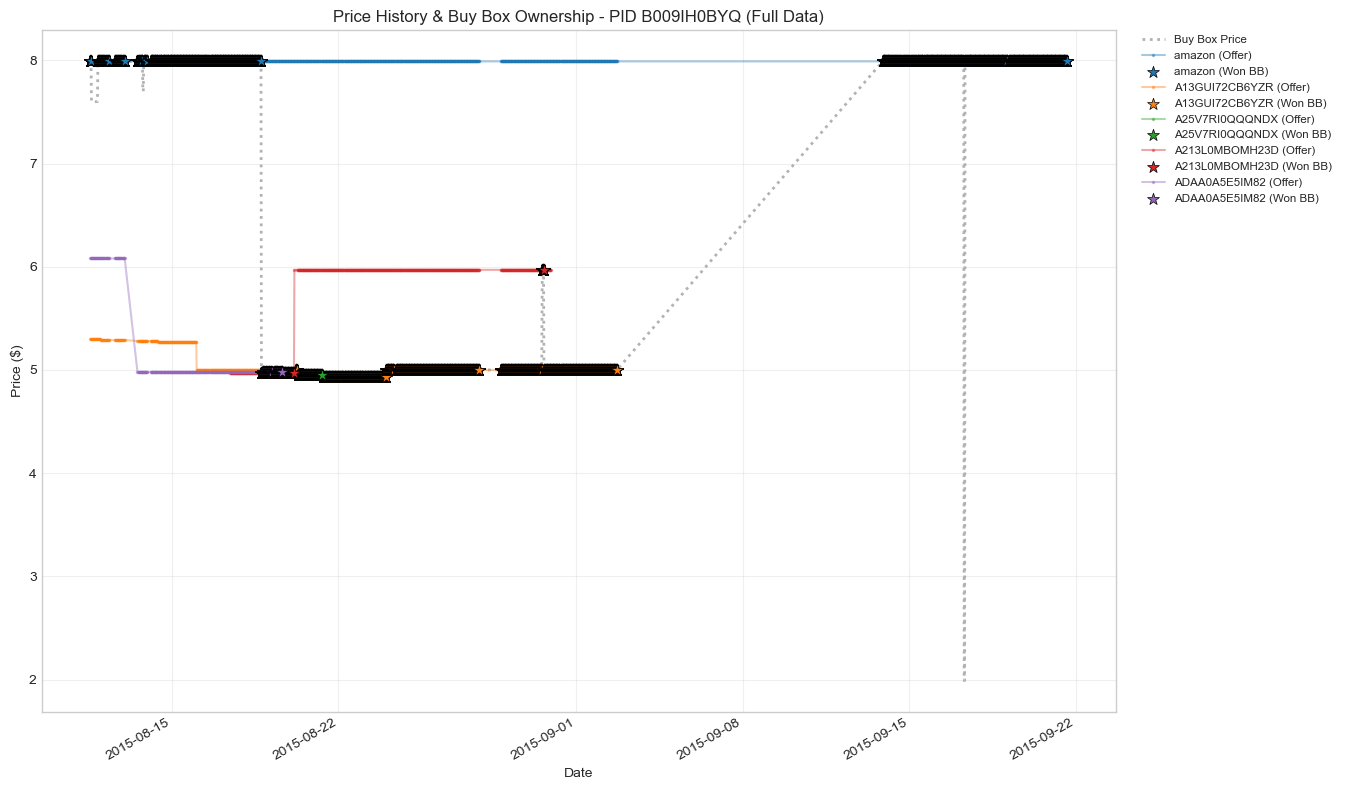



=== Analysis for Product ID: B00DJPK8PA ===

--- Detailed BuyBox Holder Analysis ---


,seller_id,total_bbox_duration_hours,avg_bbox_price_overall,min_bbox_price_overall,max_bbox_price_overall,times_won_bbox,total_observations
1,amazon,974.511111,9.160723,8.92,9.90,2,29730
0,A33W1H858N55YJ,9.040833,9.080001,9.08,9.08,1,380



--- Plotting Detailed Price History for Top BuyBox Holders ---

Plotting detailed history for top 5 Buy Box holders: ['amazon', 'A33W1H858N55YJ', 'A1QG8Z5OE5V3SM', 'A6QB1HHY3N2AV', 'A391KUJ46AEZ1J']


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15400\2857531843.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', max(10, len(top_sellers))) # Ensure enough colors


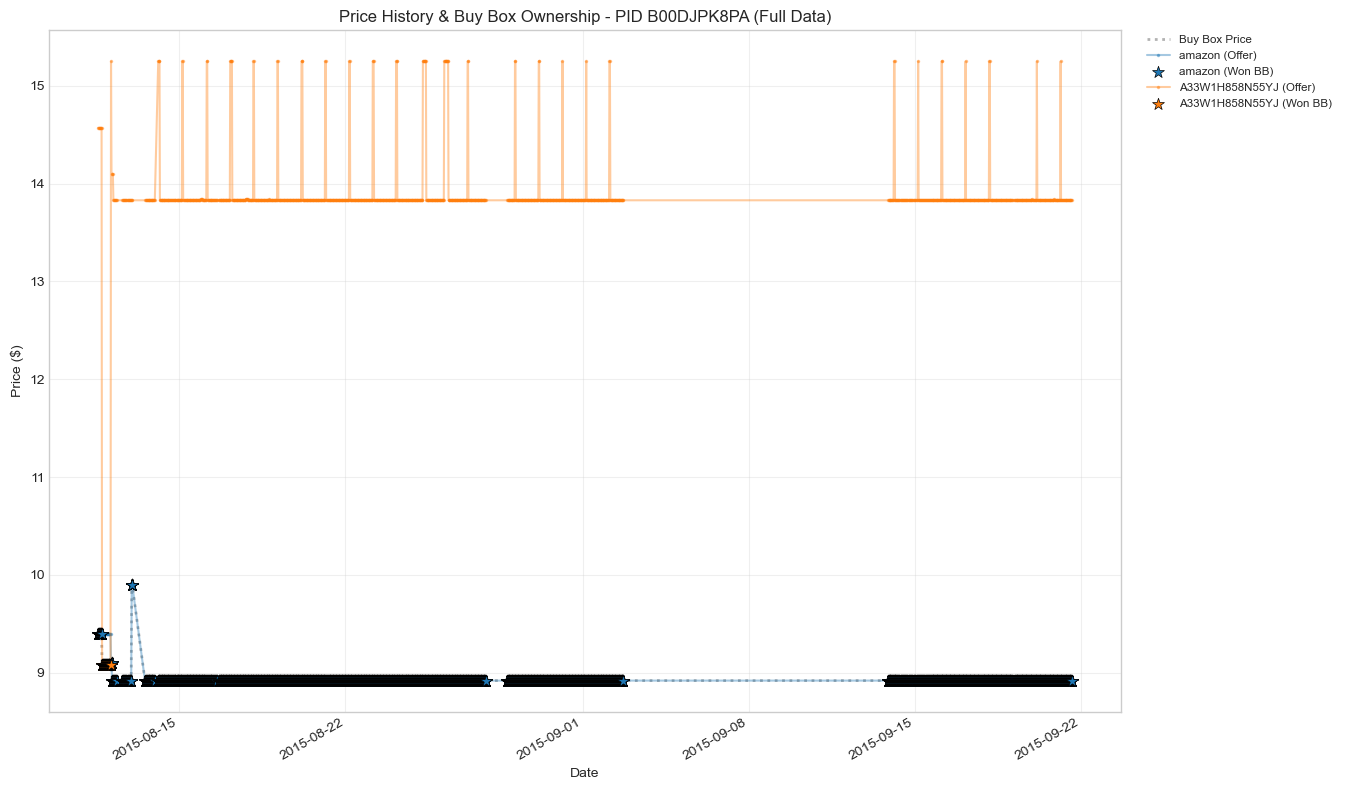



=== Analysis for Product ID: B001EOV492 ===

--- Detailed BuyBox Holder Analysis ---


,seller_id,total_bbox_duration_hours,avg_bbox_price_overall,min_bbox_price_overall,max_bbox_price_overall,times_won_bbox,total_observations
0,amazon,984.558333,25.189909,24.889999,26.49,1,30110



--- Plotting Detailed Price History for Top BuyBox Holders ---

Plotting detailed history for top 5 Buy Box holders: ['amazon', 'A31RU6EXMPM61N', 'A3956JYB8ZMS1F', 'A3D53PT1NYW20R', 'A3HAK66B5FRD6G']


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15400\2857531843.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', max(10, len(top_sellers))) # Ensure enough colors


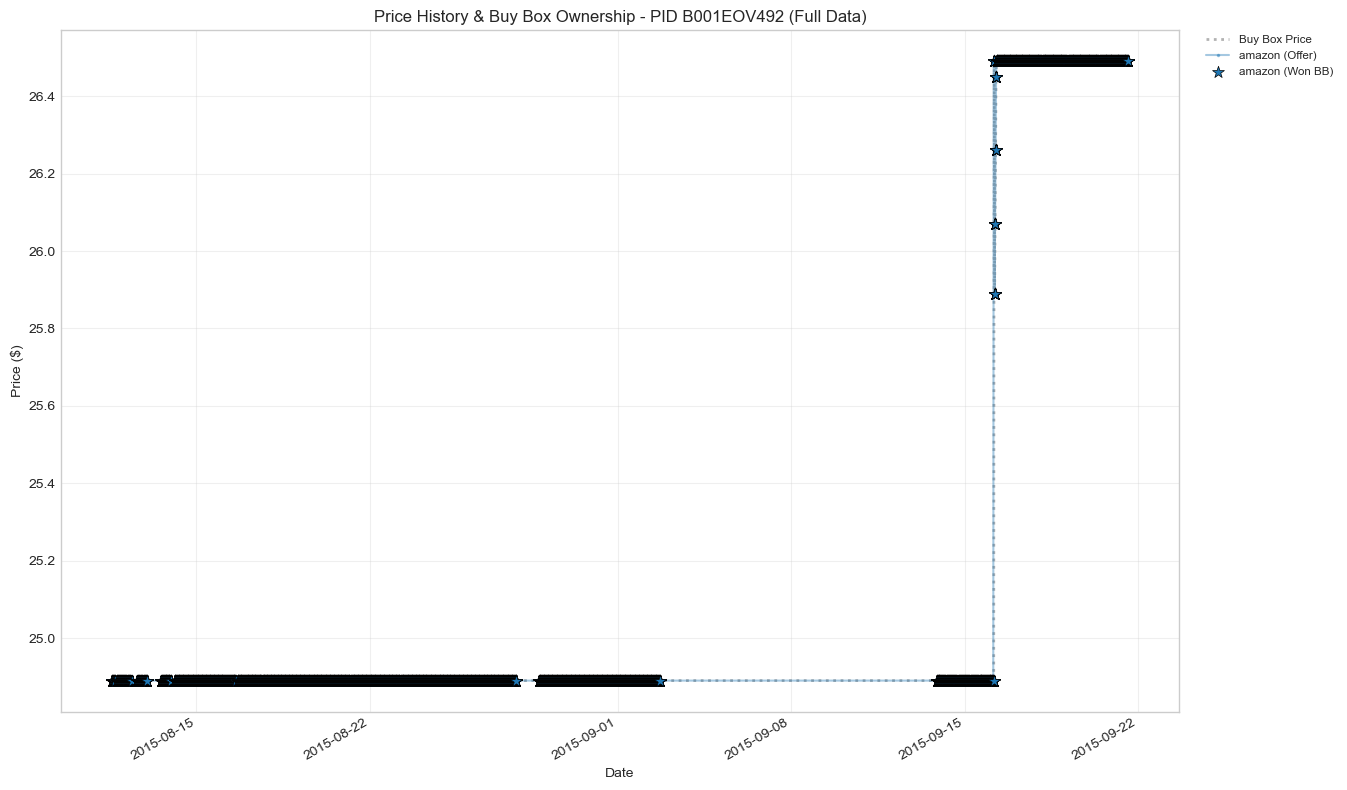



=== Analysis for Product ID: B000NCOKZQ ===

--- Detailed BuyBox Holder Analysis ---


,seller_id,total_bbox_duration_hours,avg_bbox_price_overall,min_bbox_price_overall,max_bbox_price_overall,times_won_bbox,total_observations
1,amazon,619.343611,5.175406,2.50,6.99,2,26030
0,A3BFK8XG0TA054,96.320278,0.040000,0.04,0.04,1,4080



--- Plotting Detailed Price History for Top BuyBox Holders ---

Plotting detailed history for top 5 Buy Box holders: ['amazon', 'A3BFK8XG0TA054', 'A1WDRWDN0H7BEA', 'A391KUJ46AEZ1J', 'A3956JYB8ZMS1F']


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15400\2857531843.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', max(10, len(top_sellers))) # Ensure enough colors


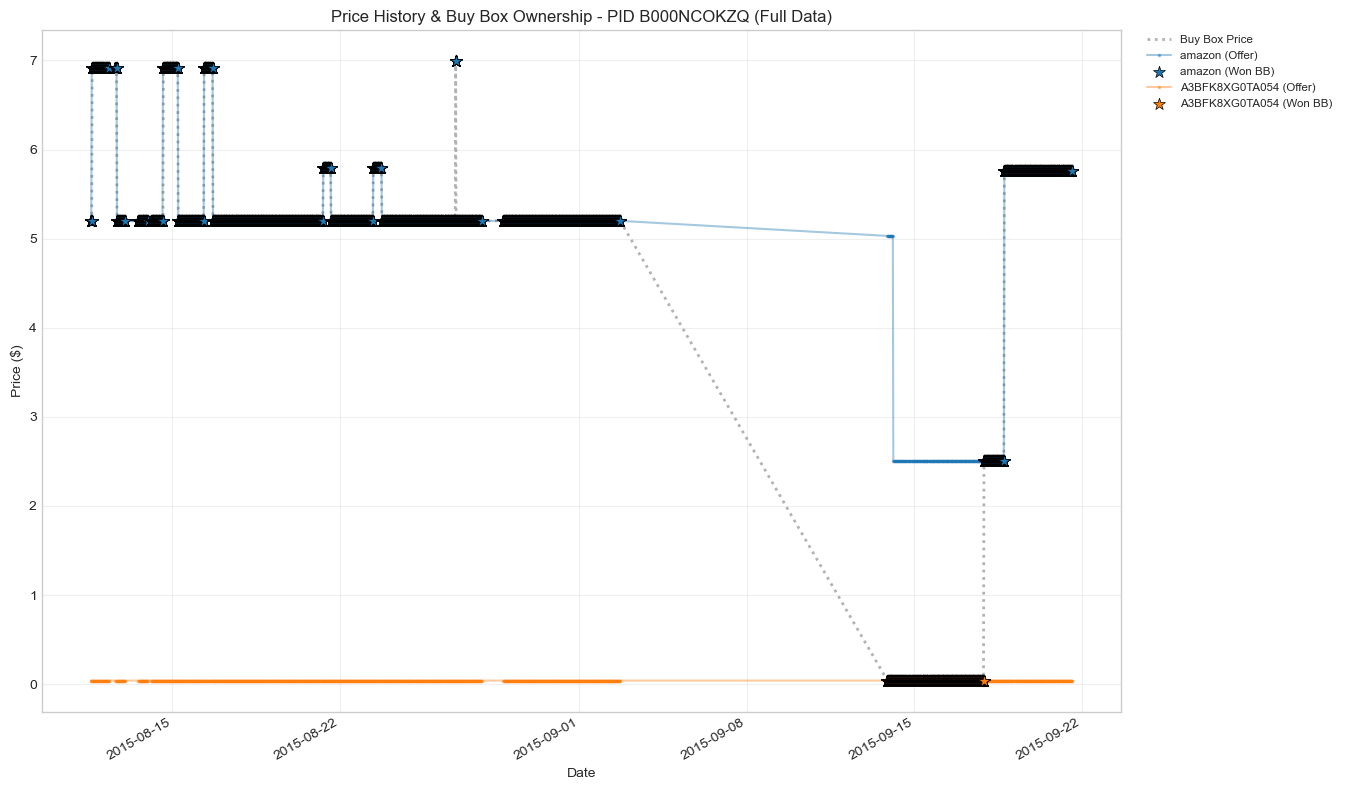



=== Analysis for Product ID: B0002E1P08 ===

--- Detailed BuyBox Holder Analysis ---


,seller_id,total_bbox_duration_hours,avg_bbox_price_overall,min_bbox_price_overall,max_bbox_price_overall,times_won_bbox,total_observations
0,amazon,984.081944,23.895966,21.02,24.99,1,30100



--- Plotting Detailed Price History for Top BuyBox Holders ---

Plotting detailed history for top 5 Buy Box holders: ['amazon', 'A31RU6EXMPM61N', 'A3956JYB8ZMS1F', 'A3D53PT1NYW20R', 'A3HAK66B5FRD6G']


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_15400\2857531843.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', max(10, len(top_sellers))) # Ensure enough colors


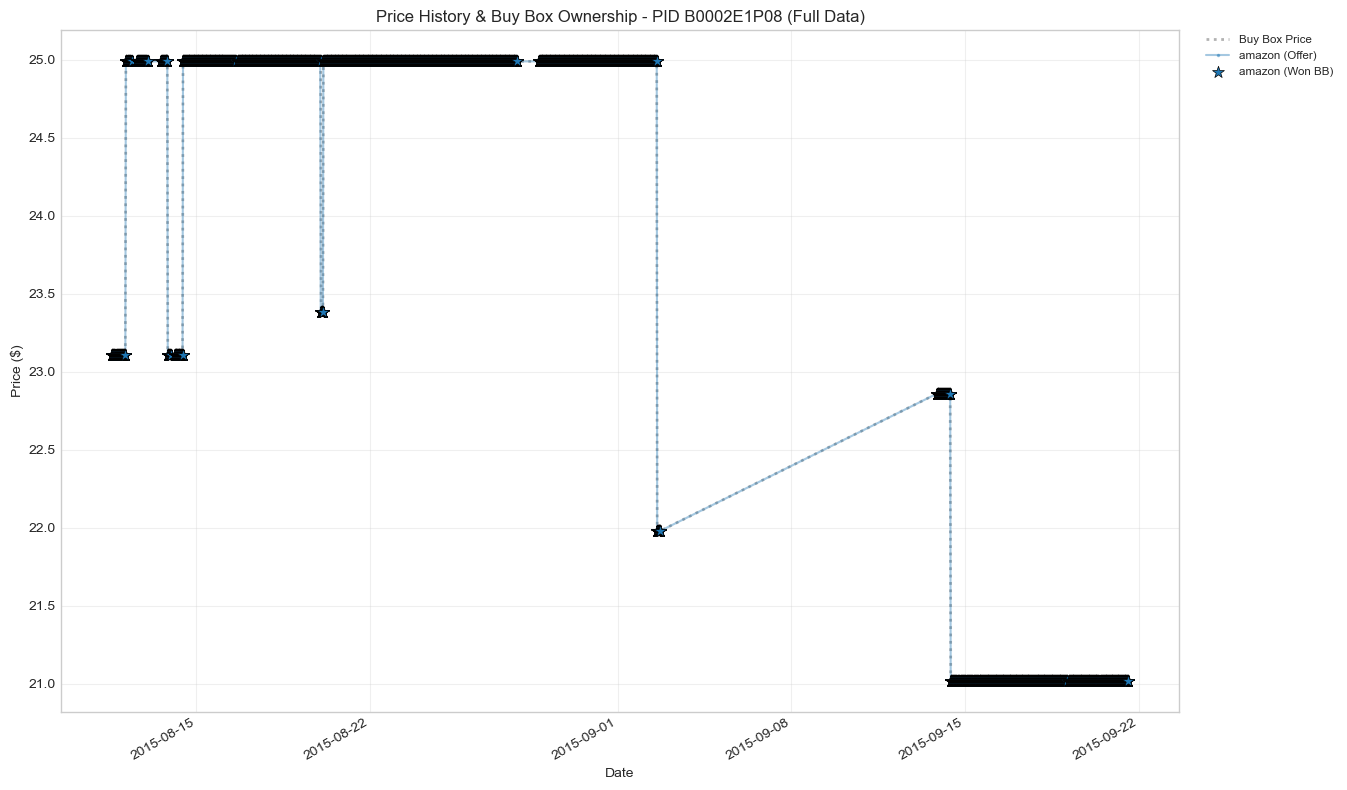

Multi-product analysis done in 8.02 sec.


In [17]:
# %% [markdown]
# ### Helper Functions for Multi-Product Price Dynamics Analysis (Section G)
# Place these definitions before Section G where they are called.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

def analyze_buybox_sellers(df, product_id):
    """Analyze BuyBox holder statistics for a given product."""
    # Filter for the product and work on a copy
    product_data_local = df[df['pid'] == product_id].copy()

    if product_data_local.empty:
        print(f"No data found for PID {product_id} in analyze_buybox_sellers.")
        return pd.DataFrame() # Return empty DataFrame

    # Ensure timestamp is present and sorted
    if 'timestamp' not in product_data_local.columns:
        print("Error: 'timestamp' column missing in analyze_buybox_sellers.")
        return pd.DataFrame()
    product_data_local = product_data_local.sort_values('timestamp')

    # Get unique BuyBox holders and their entries
    # Identify contiguous blocks of the same bbox_sid
    # Handle potential NaNs in bbox_sid shifting
    product_data_local['bbox_sid_prev'] = product_data_local['bbox_sid'].shift()
    # Compare string representations to handle NaN differences correctly
    product_data_local['bbox_change'] = product_data_local['bbox_sid'].astype(str) != product_data_local['bbox_sid_prev'].astype(str)
    product_data_local['bbox_block'] = product_data_local['bbox_change'].cumsum()

    bbox_summary = []
    # Use try-except for groupby just in case of unexpected data issues
    try:
        for block_num, block_df in product_data_local.groupby('bbox_block'):
            if not block_df.empty:
                seller = block_df['bbox_sid'].iloc[0]
                # Handle cases where seller might be NaN/None if data has issues
                if pd.isna(seller):
                    continue # Skip blocks with no valid seller ID

                start_time = block_df['timestamp'].min()
                end_time = block_df['timestamp'].max()
                duration_seconds = (end_time - start_time).total_seconds()
                # Filter NaNs before calculating price stats
                valid_prices = block_df['bbox_price'].dropna()
                avg_price = valid_prices.mean() if not valid_prices.empty else np.nan
                min_price = valid_prices.min() if not valid_prices.empty else np.nan
                max_price = valid_prices.max() if not valid_prices.empty else np.nan
                observation_count = len(block_df) # Count all rows in the block

                bbox_summary.append({
                    'seller_id': seller,
                    'start_time': start_time,
                    'end_time': end_time,
                    'bbox_duration_seconds': duration_seconds,
                    'avg_bbox_price': avg_price,
                    'min_bbox_price': min_price,
                    'max_bbox_price': max_price,
                    'observation_count': observation_count
                })
    except Exception as e:
         print(f"Error during groupby in analyze_buybox_sellers: {e}")
         return pd.DataFrame()


    if not bbox_summary:
        print(f"No valid BuyBox blocks found for PID {product_id}.")
        return pd.DataFrame()

    summary_df = pd.DataFrame(bbox_summary)

    # Aggregate stats per seller
    agg_summary = summary_df.groupby('seller_id').agg(
        total_bbox_duration_hours=('bbox_duration_seconds', lambda x: x.sum() / 3600),
        avg_bbox_price_overall=('avg_bbox_price', 'mean'), # Mean of the average price during each tenure
        min_bbox_price_overall=('min_bbox_price', 'min'),
        max_bbox_price_overall=('max_bbox_price', 'max'),
        times_won_bbox=('seller_id', 'size'), # Number of blocks they held bbox
        total_observations=('observation_count', 'sum')
    ).reset_index().sort_values('total_observations', ascending=False) # Sort by obs count

    # Clean up intermediate dataframes
    del product_data_local, summary_df
    gc.collect()

    return agg_summary

def plot_buybox_seller_prices(df, product_id, top_n_sellers=5):
    """Plot price history and BuyBox ownership for top sellers of a product."""
    product_data_local = df[df['pid'] == product_id].copy()

    if product_data_local.empty:
        print(f"No data to plot for PID {product_id}")
        return None

    if 'timestamp' not in product_data_local.columns:
        print("Error: 'timestamp' column missing in plot_buybox_seller_prices.")
        return None
    product_data_local = product_data_local.sort_values('timestamp')
    product_data_local.set_index('timestamp', inplace=True) # Use timestamp index for plotting

    # Determine top N sellers by frequency of *holding* the BuyBox
    # Ensure bbox_sid is treated correctly (handle potential NaNs)
    valid_bbox_sids = product_data_local['bbox_sid'].dropna()
    if valid_bbox_sids.empty:
        print(f"No valid BuyBox holders found to determine top sellers for PID {product_id}")
        return None
    top_sellers = valid_bbox_sids.value_counts().head(top_n_sellers).index.tolist()

    if not top_sellers:
        print(f"Could not determine top sellers for PID {product_id}")
        return None

    print(f"\nPlotting detailed history for top {len(top_sellers)} Buy Box holders: {top_sellers}")

    plt.figure(figsize=(16, 8))
    plot_title_suffix = " (Sample Data)" if USE_SAMPLE else " (Full Data)" # Assumes USE_SAMPLE is global

    # Plot BuyBox price line (use unique timestamps from the local df)
    bbox_unique_time = product_data_local[~product_data_local.index.duplicated(keep='first')]
    plt.plot(bbox_unique_time.index, bbox_unique_time['bbox_price'],
             color='gray', alpha=0.6, linestyle=':', linewidth=2, label='Buy Box Price', zorder=1)

    # Plot each top seller's price history and BuyBox moments
    # Use a robust colormap that handles varying numbers of sellers
    colors = plt.cm.get_cmap('tab10', max(10, len(top_sellers))) # Ensure enough colors

    for i, seller in enumerate(top_sellers):
        # Filter for this seller's offers
        seller_data = product_data_local[product_data_local['sid'] == seller]
        if seller_data.empty: continue

        # Plot regular price points (slightly transparent)
        # Use unique index points for cleaner plotting if many duplicates
        seller_price_unique = seller_data[~seller_data.index.duplicated(keep='first')]
        plt.plot(seller_price_unique.index, seller_price_unique['price'],
                 alpha=0.4, color=colors(i % 10), marker='.', linestyle='-', markersize=3, # Use modulo for color index
                 label=f'{str(seller)[:15]}... (Offer)' if len(str(seller)) > 15 else f'{seller} (Offer)')

        # Highlight points where this seller had the BuyBox
        # Filter original local data (before setting index) for when this seller held BB
        # Ensure index is reset or use the original df slice
        bbox_data = product_data_local[product_data_local['bbox_sid'] == seller]

        if not bbox_data.empty:
            # Plot markers where seller won BB (use the bbox_price at that time)
            plt.scatter(bbox_data.index, bbox_data['bbox_price'], # Use bbox_price for marker position
                        color=colors(i % 10), s=80, marker='*',
                        label=f'{str(seller)[:15]}... (Won BB)' if len(str(seller)) > 15 else f'{seller} (Won BB)',
                        edgecolors='black', linewidth=0.5, zorder=5) # Make stars stand out

    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'Price History & Buy Box Ownership - PID {product_id}{plot_title_suffix}')
    plt.xticks(rotation=30, ha='right')
    # Adjust legend position
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='small')
    plt.grid(True, alpha=0.3)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout further if legend overlaps
    plt.show()

    # Clean up
    del product_data_local, bbox_unique_time, valid_bbox_sids
    gc.collect()

    return top_sellers


def analyze_price_changes(df, product_id, seller_id):
    """Analyze price changes when entering/leaving BuyBox for a specific seller."""
    product_data_local = df[df['pid'] == product_id].copy()

    if 'timestamp' not in product_data_local.columns:
        print("Error: 'timestamp' column missing in analyze_price_changes.")
        return None, None
    product_data_local = product_data_local.sort_values('timestamp')

    # Filter for rows where this seller is present
    seller_data = product_data_local[product_data_local['sid'] == seller_id].copy()
    if seller_data.empty:
        print(f"No offer data found for seller {seller_id} on product {product_id}.")
        return None, None

    # Mark when this seller holds the BuyBox in their specific row
    # Compare as strings to handle categories robustly
    seller_data['in_buybox'] = seller_data['bbox_sid'].astype(str) == str(seller_id)

    # Detect changes in BuyBox status *for this seller*
    # Convert boolean to int (0/1) before diff, fill first NA with 0
    seller_data['buybox_status_change'] = seller_data['in_buybox'].astype(int).diff().fillna(0)
    # change == 1 means entered BuyBox (False -> True)
    # change == -1 means left BuyBox (True -> False)

    enter_bbox_moments = seller_data[seller_data['buybox_status_change'] == 1]
    leave_bbox_moments = seller_data[seller_data['buybox_status_change'] == -1]

    # Calculate total time in BuyBox by summing durations between observations where seller held BB
    time_in_bbox_seconds = 0
    # Iterate through rows where seller WAS in buybox, calculate time diff to NEXT observation
    in_bbox_indices = seller_data[seller_data['in_buybox']].index
    if len(in_bbox_indices) > 0:
        # Get timestamps for rows where in_buybox is True and the next row
        ts_in_bbox = seller_data.loc[in_bbox_indices, 'timestamp']
        # Shift timestamps to get the next observation time (even if not in bbox)
        # Need to shift across the whole seller_data, then align
        ts_next_obs = seller_data['timestamp'].shift(-1)
        ts_next_aligned = ts_next_obs.loc[in_bbox_indices]

        # Calculate time difference only where next timestamp exists
        valid_diffs = ts_next_aligned.notna()
        time_diffs = (ts_next_aligned[valid_diffs] - ts_in_bbox[valid_diffs]).dt.total_seconds()

        # Optional: Cap duration to avoid huge gaps (e.g., max 1 day gap = 1 valid observation period)
        max_gap_seconds = 24 * 3600
        time_diffs_capped = time_diffs[time_diffs < max_gap_seconds]

        time_in_bbox_seconds = time_diffs_capped.sum()


    # Calculate avg prices, handling empty dataframes
    avg_price_entering = enter_bbox_moments['price'].dropna().mean() if not enter_bbox_moments.empty else np.nan
    avg_price_leaving = leave_bbox_moments['price'].dropna().mean() if not leave_bbox_moments.empty else np.nan


    stats = {
        'seller_id': seller_id,
        'entries_observed': len(enter_bbox_moments),
        'exits_observed': len(leave_bbox_moments),
        'avg_price_when_entering': avg_price_entering,
        'avg_price_when_leaving': avg_price_leaving,
        'estimated_total_time_in_bbox_hours': time_in_bbox_seconds / 3600 if time_in_bbox_seconds else 0
    }

    # Clean up
    del product_data_local, seller_data, enter_bbox_moments, leave_bbox_moments
    gc.collect()

    # Return stats and potentially seller_data for further inspection if needed (but clear it mostly)
    return stats, None # Return None for data to save memory


# %%
# --- Ensure Garbage Collection is Imported ---
import gc
N_PRODUCTS_TO_ANALYZE = 5 # Keep this reasonably small

if not analysis_data.empty:
    print(f"\n--- Analyzing Price Dynamics for Top {N_PRODUCTS_TO_ANALYZE} Products ---")
    product_analysis_start = time.time()

    # Get PIDs with the most observations (efficient)
    top_pids = analysis_data['pid'].value_counts().head(N_PRODUCTS_TO_ANALYZE).index.tolist()

    if not top_pids:
        print("No products found to analyze (possibly after sampling).")
    else:
        print(f"Selected PIDs for analysis: {top_pids}")

        # --- Ensure helper functions from original Section E are defined ---
        # analyze_buybox_sellers(df, product_id)
        # plot_buybox_seller_prices(df, product_id, top_n_sellers=5)
        # analyze_price_changes(df, product_id, seller_id)
        # --- (Definitions assumed to be present) ---

        try:
             # Make sure the functions needed are defined
             _ = analyze_buybox_sellers # Check if function exists
             _ = plot_buybox_seller_prices
             _ = analyze_price_changes

             for pid_to_analyze in top_pids:
                 print(f"\n\n=== Analysis for Product ID: {pid_to_analyze} ===")
                 # Filtering for one product is memory-efficient
                 # ... (rest of the multi-product analysis loop as before) ...
                 # This part operates on smaller subsets, less likely to cause memory issues

                 print("\n--- Detailed BuyBox Holder Analysis ---")
                 # Pass analysis_data, which might be the sample
                 bbox_holder_summary = analyze_buybox_sellers(analysis_data, pid_to_analyze)
                 if not bbox_holder_summary.empty:
                      display(bbox_holder_summary.head())
                 else:
                      print("Could not generate BuyBox holder summary.")

                 print("\n--- Plotting Detailed Price History for Top BuyBox Holders ---")
                 top_buybox_sellers = plot_buybox_seller_prices(analysis_data, pid_to_analyze, top_n_sellers=5)
                 # ... (rest of the loop, including price change analysis) ...


        except NameError as e:
             print(f"\nError: A required analysis function is missing: {e}")
             print("Please ensure 'analyze_buybox_sellers', 'plot_buybox_seller_prices', and 'analyze_price_changes' are defined.")
        except Exception as e:
             print(f"\nAn error occurred during multi-product analysis: {e}")


    print(f"Multi-product analysis done in {time.time() - product_analysis_start:.2f} sec.")
else:
    print("\nSkipping Multi-Product Specific analysis as data is empty.")



 ## End of Analysis

 This notebook performed optimized EDA and modeling for large datasets. Remember that results derived from samples may differ from results on the full dataset. Further optimization might involve distributed computing frameworks or more advanced incremental learning techniques.

In [ ]:
print("Notebook execution finished.")